In [1]:
import os
import random
import sys

import time

import yaml

from pathlib import Path

from copy import deepcopy

import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image, ImageReadMode
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_model_summary import summary

from fLossFunctions import v8DetectionLoss
from fValidation import v8DetectionValidator

from collections import defaultdict
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
params = {
    "data_dir": '/media/pipeh/Data/Datasets/Merged_Apple_Dataset', #"/media/pipeh/Data/Datasets/Merged_Apple_Dataset", # "D:/Datasets/Merged_Apple_Dataset",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_pth": "checkpoint/mixed",
    "batch_size": 32,
    "epochs": 200,
    "img_size": 320,
    "mixup_thr": 1.,
    "reg_max": 4,
    "version": 'v3',
}

## Build datasets

In [3]:
class DetectionDataset(Dataset):
    """
    SuperClass with pytorch Dataset methods to manage an object detection dataset, loading its images
    with its labels and applying the basic data augmentation pipelines.
    
    Args:
        args (dict): script hyper parameters and arguments.
        partition (string): Dataset mode for train or test partition and data augmentations.
        transform (Albumentation Compose): Data augmentation pipeline for images in train or test.
    
    Attributes:
        mode (String): dataset mode: train or test.
        subset_images (string): image dataset subset folder name.
        subset_labels (string): labels dataset subset folder name.
        mosaic (bool): flag if use mosaic images.
        transform (Albumentation Compose): data augmentation pipeline.
        img_size (int): image size w,h to resize images.
        file_ids (list): names of the files of the images.
        
    Methods:
        __len__(self): return the lenght of dataset subset.
        __getitem__(self, idx): return a batch composed by images, its bboxes and classes labels for each box, depending if
                                mixup augmentation is true.
        load_image(self, idx): load and return a single sample composed by an image, its bboxes and classes labels for each box.
    """
    
    def __init__(self, args, partition=None, transform=None):
        super(DetectionDataset, self).__init__()
        self.params = args
        self.mode = partition
        self.img_size = args["img_size"]
        self.transform = transform
        
        self.subset_images = self.subset_labels = ''
        if self.mode == 'train':
            self.subset_images += 'train'
            self.subset_labels += 'train'                
        else:
            self.subset_images += 'val'
            self.subset_labels += 'val'
        
        self.file_ids = os.listdir(f'{self.params["data_dir"]}/labels/{self.subset_labels}')
    
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        image, bboxes, labels = self.load_image(idx)
        return image, bboxes, labels
        
    def load_image(self, idx):
        file_name = self.file_ids[idx]
        bboxes = []
        labels = []
        try:
            image = read_image(f'{params["data_dir"]}/images/{self.subset_images}/{file_name[:-4]}.jpg', ImageReadMode.RGB)
        except:
            image = read_image(f'{params["data_dir"]}/images/{self.subset_images}/{file_name[:-4]}.png', ImageReadMode.RGB)
        with open(f'{self.params["data_dir"]}/labels/{self.subset_labels}/{file_name}', 'r') as f:
            for line in f.readlines():
                line_data = list(map(float, line.strip().split()))
                labels.append(int(0.))
                bboxes.append(line_data[1:])
        transformed = self.transform(image=np.array(image.permute(1,2,0), np.float32) / 255., 
                                     bboxes=bboxes, 
                                     class_labels=labels)
        image = transformed['image']
        bboxes = transformed['bboxes']
        labels = transformed['class_labels']
        bboxes = torch.tensor(bboxes)
        labels = torch.tensor(labels).unsqueeze(dim=-1)
        return image, bboxes, labels

In [4]:
class ProcessBatch(object):
    """
    Preprocessing class that takes a list of tuples of images, bboxes and labels and arranges them as a batch of
    given lenght, and applies MixUp augmentation if a random probability surprass a threshold.
    
    Attributes:
        n_max_boxes (int): maxium number of zeros batch padding.
        thr (float): threshold to apply mixup augmentation
        
    Methods_
        __call__(self, batch): return a batched set of images, bounding boxes and labels.
        pad_batch(self, batch): return a batched set of images, bounding boxes and labels.
        mixup_batch(self, batch): return a batched set of images, bounding boxes and labels with MixUp augmentation
                                with its same batch but randomly shuffled.
                                
    """
    def __init__(self, thr=0.5):
        self.n_max_boxes = 128
        self.n_max_boxes_mixup = 256
        self.thr = thr
        
    def __call__(self, batch):
        if random.random() < self.thr:
            images, bboxes, labels = self.mixup_batch(batch)
            return images, bboxes, labels
        else:
            images, bboxes, labels = self.normal_batch(batch)
            return images, bboxes, labels

    def normal_batch(self, batch):
        img_tuple, bboxes_tuple, labels_tuple = zip(*batch)
        images  = torch.stack(list(img_tuple), dim=0)
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for box,label in zip(bboxes_tuple, labels_tuple):
            box, label = self.pad_batch(box, label, self.n_max_boxes)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return images, bboxes, labels
    
    def mixup_batch(self, batch):
        img_x, bboxes_x, labels_x = zip(*batch)
        batch = list(batch)
        batch.append(batch.pop(0))
        img_y, bboxes_y, labels_y = zip(*batch)
        img_x  = torch.stack(list(img_x), dim=0)
        img_y  = torch.stack(list(img_y), dim=0)
        alpha = (0.6 - 0.4) * torch.rand(img_x.size(0), 1, 1, 1) + 0.4
        img = alpha * img_x + (1 - alpha) * img_y
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for boxA, boxB, labelA, labelB in zip(bboxes_x, bboxes_y, labels_x, labels_y):
            box = torch.cat([boxA, boxB], dim=0)
            label = torch.cat([labelA, labelB], dim=0)
            box, label = self.pad_batch(box, label, self.n_max_boxes_mixup)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return img, bboxes, labels
    
    def pad_batch(self, bboxes, labels, nmax):
        bs = bboxes.shape[0]
        n = nmax - bs
        if n>0:
            bboxes = torch.cat([bboxes, torch.zeros(n,4)])
            labels = torch.cat([labels, torch.zeros(n,1)])
        elif n<0:
            bboxes = bboxes[:nmax]
            labels = labels[:nmax]
        return bboxes, labels

In [5]:
def build_dataloader(args, transforms):
    """
    Function to build dataset given a directory path and a set of transforms pipeline.
    
    Args:
        args (dict): script hyper parameters and arguments.
        transforms (dict): Different data augmentation pipelines for images in train or test.
        
    Return:
        dataset (Dataset): the builded dataset of a given subset.
        dataloader (Dataloader): the dataloader method for the dataset.
    """
    dataset = dict()
    dataloader = dict()
    transform = transforms
    for x in ['train', 'val']:
        dataset[x] = DetectionDataset(
            args,
            partition=x,
            transform=transform[x]
        )
        if x == 'train':
            preprocces_batch = ProcessBatch(thr=args["mixup_thr"])
        else:
            preprocces_batch = ProcessBatch(thr=0.)            
        dataloader[x] = DataLoader(
            dataset[x],
            batch_size=args["batch_size"],
            collate_fn=preprocces_batch,
            num_workers=4,
            shuffle=True,
        )
    return dataset, dataloader

In [6]:
data_transforms = {
    'train': A.Compose([
        #A.LongestMaxSize (max_size=params['img_size']),
        #A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        A.SmallestMaxSize (max_size=params['img_size']),
        A.RandomCrop (height=params['img_size'], width=params['img_size']),
        #A.Resize (params['img_size'], params['img_size']),
        A.ShiftScaleRotate (shift_limit=0., scale_limit=[0., 0.9], rotate_limit=0., p=1.0),
        A.ColorJitter (p=1.0),
        A.HorizontalFlip (p=0.5),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                min_area=0.0,
                                min_visibility=0.0,
                                label_fields=['class_labels'])),
    'val': A.Compose([
        #A.SmallestMaxSize (max_size=params['img_size']),
        #A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                label_fields=['class_labels'])),
}

In [7]:
dataset, dataloader = build_dataloader(params, data_transforms)
dataset_sizes = {x: len(dataset[x]) for x in ['train','val']}
print(f"dataset_sizes {dataset_sizes}")

classes = {0: 'fruit'}

nclasses = len(classes)
print(f'number of classes: {nclasses} \nclasses: {[v for x,v in classes.items()]}')

dataset_sizes {'train': 2174, 'val': 397}
number of classes: 1 
classes: ['fruit']


In [8]:
def visualize_coco_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [9]:
def visualize_dataset(dataloader, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        dataloader (Dataloader): dataloader of the dataset subset to extract sample.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """
    image, bboxes, category_ids = next(iter(dataloader))
    image = image[0].unsqueeze(0)
    bboxes = bboxes[0].unsqueeze(0)
    category_ids = category_ids[0].unsqueeze(0)
    mask_gt = bboxes.sum(2, keepdim=True).gt_(0)
    bs = bboxes.shape[0]
    bboxes = bboxes[mask_gt.expand(-1, -1, 4).bool()].view(bs, -1, 4)
    category_ids = category_ids[mask_gt.bool()].view(bs, -1, 1)
    img = image[0].permute(1,2,0).numpy().copy()
    for bbox, category_id in zip(bboxes.numpy()[0], category_ids.numpy()[0]):
        class_name = category_id_to_name[category_id[0]]
        img = visualize_coco_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


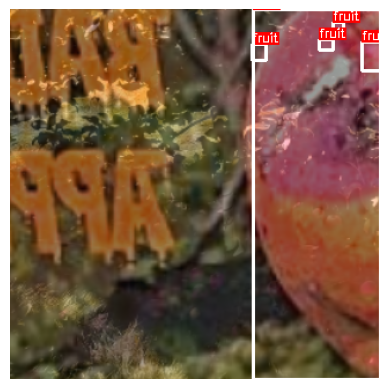

In [10]:
visualize_dataset(dataloader['train'], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


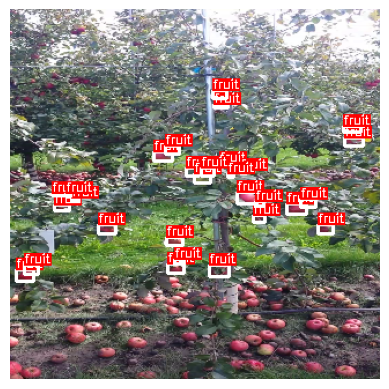

In [11]:
visualize_dataset(dataloader['val'], classes)

## Build detection model

In [12]:
class ConvModule(nn.Module):
    """ 
    Convolutional block composed of conv->batchnorm->relu. 
    """
    def __init__(self, cin=1, cout=1, k=1, s=1, p=0, device='cpu'):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(cin, cout, (k, k), stride=s, padding=p, bias=False).to(device)
        self.bn = nn.BatchNorm2d(cout, eps=0.001, momentum=0.03, affine=True, track_running_stats=True).to(device)
        self.silu = nn.SiLU(inplace=True).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

In [13]:
class Bottleneck(nn.Module):
    """ 
    Bottleneck block componsed of conv->conv->residual connection. 
    """
    def __init__(self, c=1, shortcut=False, device='cpu'):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c//2, k=3, s=1, p=1, device=device)
        self.conv2 = ConvModule(cin=c//2, cout=c, k=3, s=1, p=1, device=device)
        self.shortcut = shortcut

    def forward(self, x):
        xin = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut==True:
            x = xin + x
            return x
        return x

In [14]:
class C2f(nn.Module):
    """ 
    C2f module (cross-stage partial bottleneck with two convolutions) which combines 
    high-level features with contextual information to improve detection accuracy. 
    """
    def __init__(self, cin=1, cout=1, depth=1, device='cpu'):
        super(C2f, self).__init__()
        self.cout = cout
        self.depth = depth
        self.convmodule1 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        self.bottleneck = []
        for _ in range(depth):
            self.bottleneck.append(Bottleneck(c=self.cout//2, shortcut=True, device=device))
        cin = cout//2 * (depth+2)
        self.convmodule2 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x1 = self.convmodule1(x)
        x1_1, x1_2 = torch.split(x1, self.cout//2, dim=1)
        x3 = torch.cat([x1_1, x1_2],dim=1)
        for i in range(len(self.bottleneck)):
            x2 = self.bottleneck[i](x1_2)
            x3 = torch.cat([x3, x2], dim=1)
            x1_2 = x2
        x = self.convmodule2(x3)
        return x

In [15]:
class SPPF(nn.Module):
    """ 
    Spatial pyramid pooling fast module (SPPF) layer accelerates computation 
    by pooling features into a fixed-size map. 
    """
    def __init__(self, c=1, device='cpu'):
        super(SPPF, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c, k=1, s=1, p=0, device=device)
        self.mp1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp3 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.conv2 = ConvModule(cin=c*4, cout=c, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x = self.conv1(x)
        x1 = self.mp1(x)
        x2 = self.mp2(x1)
        x3 = self.mp3(x2)
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

In [16]:
class DetectionHead(nn.Module):
    """
    Detection head module, which is decoupled to regression, classification, 
    and depth central pixel estimation tasks independently.
    """
    def __init__(self, c=1, reg_max=1, nclass=1, device='cpu'):
        super(DetectionHead, self).__init__()
        d = max(c, reg_max*4)
        self.bboxconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv3 = nn.Conv2d(d, 4*reg_max, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.clsconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv3 = nn.Conv2d(d, nclass, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.dptconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv3 = nn.Conv2d(d, 1, (1, 1), stride=1, padding=0, bias=False).to(device)
        
    def forward(self, x):
        # bbox branch
        xbbox = self.bboxconv1(x)
        xbbox = self.bboxconv2(xbbox)
        xbbox = self.bboxconv3(xbbox)
        # cls branch
        xcls = self.clsconv1(x)
        xcls = self.clsconv2(xcls)
        xcls = self.clsconv3(xcls)
        # depth branch
        xdpt = self.dptconv1(x)
        xdpt = self.dptconv2(xdpt)
        xdpt = self.dptconv3(xdpt)
        
        feats = torch.cat([xbbox, xcls, xdpt], dim=1) 
        return feats

In [17]:
class DFL(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """
    def __init__(self, c1=16, device='cpu'):
        """Initialize a convolutional layer with a given number of input channels."""
        super(DFL, self).__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False).to(device)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)

In [18]:
class Inference(nn.Module):
    def __init__(self, nclasses=1, stride=None, reg_max=1, device='cpu'):
        super(Inference, self).__init__()
        self.stride = stride
        self.nc = nclasses
        self.reg_max = reg_max
        self.no = self.reg_max*4 + nclasses + 1
        self.dfl = DFL(self.reg_max, device=device) #if self.reg_max > 1 else nn.Identity()
        
    def forward(self, feats):
        # Extract predictions from each head at different strides
        pred_distri, pred_scores, pred_depth = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split((self.reg_max*4, self.nc, 1), 1)
        pred_scores = pred_scores.permute(0, 1, 2).contiguous() # (b, nc, h*w)
        pred_distri = pred_distri.permute(0, 1, 2).contiguous() # (b, 4*reg_max, h*w)
        pred_depth = pred_depth.permute(0, 1, 2).contiguous() # (b, 1, h*w)
        # Get anchor point centers from output grids and its corresponding stride
        anchors, strides = (x.transpose(0, 1) for x in self.make_anchors(feats, self.stride, 0.5))
        # Decode reg_max*4 prediction to cxywh bounding box prediction
        dbox = self.dist2bbox(self.dfl(pred_distri), anchors.unsqueeze(0), xywh=True, dim=1).clamp_(0.) * strides
        y = torch.cat((dbox, pred_scores.sigmoid(), pred_depth.sigmoid()), 1) # (bs, 4 + nclasses + depth, h*w)
        return y
    
    def dist2bbox(self, distance, anchor_points, xywh=True, dim=-1):
        """Transform distance(ltrb) to box(xywh or xyxy).
                width and height of bounding box are in range [0, 2*(self.reg_max-1)] owing to (x2y2-x1y1=rb+lt) 
        """
        lt, rb = distance.chunk(2, dim) # lt and rb is in range[0, self.reg_max-1] 
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        if xywh:
            c_xy = (x1y1 + x2y2) / 2
            wh = x2y2 - x1y1
            return torch.cat((c_xy, wh), dim)  # xywh bbox
        return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

    def make_anchors(self, feats, strides, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points, stride_tensor = [], []
        assert feats is not None
        dtype, device = feats[0].dtype, feats[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = feats[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
            sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
            sy, sx = torch.meshgrid(sy, sx, indexing='ij')
            anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        return torch.cat(anchor_points), torch.cat(stride_tensor)

In [19]:
class ObjectDetector(nn.Module):
    """
    Object Detection model inspired on YOLOv8 from Ultralytics (https://docs.ultralytics.com/models/yolov8/#supported-tasks).
    The features maps has been divided by two respect the nano version, 
    in order to reduce model size for edge devices.
    The detection head incorportes a new feature: a decoupled head for 
    depth estimation of the central pixel of the regressed bounding boxes.
    
    Args:
        nclasses (int): number of classes in the classification task of bounding boxes.
        device (string): device to initiate and proccess weights; cpu or cuda.
    
    Attributes:
        convX (nn.Conv2d): two dimensional convolution layer to extract features along
                           different resolution maps.
        sppf (nn.Module): spatial pyramid pooling fast module.
        c2f_x (nn.Module): cross-stage partial bottleneck module.
        upsample (nn.Upsample): upsampling layer to concatenate features in the neck 
                                control connections.
        headX (nn.Module): detection head for different features resolution maps.
        
    Methods:
        forward(self, x): forward given input along detection model.
    """
    def __init__(self, nclasses=1, reg_max=1, device='cpu'):
        super(ObjectDetector, self).__init__()

        self.conv1 = ConvModule(cin=3, cout=16, k=3, s=2, p=1, device=device)
        self.conv2 = ConvModule(cin=16, cout=32, k=3, s=2, p=1, device=device)
        self.conv3 = ConvModule(cin=32, cout=64, k=3, s=2, p=1, device=device)
        self.conv4 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv5 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv6 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv7 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        
        self.sppf = SPPF(c=64, device=device)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(device)

        self.c2f_1 = C2f(cin=32, cout=32, depth=1, device=device)
        self.c2f_2 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_3 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_4 = C2f(cin=64, cout=64, depth=1, device=device)
        self.c2f_5 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_6 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_7 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_8 = C2f(cin=128, cout=64, depth=1, device=device)
        
        self.head1 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head2 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head3 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        
        #self.inference = Inference(nclasses=nclasses, stride=torch.tensor([8,16,32]), reg_max=reg_max, device=device)
        
    def forward(self, x):

        ## ------------------------------ BACKBONE ------------------------------------
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        c2f_1 = self.c2f_1(x2)
        x3 = self.conv3(c2f_1)
        c2f_2 = self.c2f_2(x3)
        x4 = self.conv4(c2f_2)
        c2f_3 = self.c2f_3(x4)
        x5 = self.conv5(c2f_3)
        c2f_4 = self.c2f_4(x5)
        sppf = self.sppf(c2f_4)
        
        ## ------------------------------ NECK ------------------------------------
        ## process branch
        up_1 = self.upsample(sppf)
        cat_1 = torch.cat([up_1, c2f_3], dim=1)
        c2f_5 = self.c2f_5(cat_1)      
        up_2 = self.upsample(c2f_5)    
        cat_2 = torch.cat([up_2, c2f_2], dim=1)
        c2f_6 = self.c2f_6(cat_2)

        ## error feedback branch
        x6 = self.conv6(c2f_6)
        cat_3 = torch.cat([x6, c2f_5], dim=1)
        c2f_7 = self.c2f_7(cat_3)
        x7 = self.conv7(c2f_7)
        cat_4 = torch.cat([x7, sppf], dim=1)
        c2f_8 = self.c2f_8(cat_4)
    
        ## ------------------------------ HEAD ----------------------------------
        head1 = self.head1(c2f_6)
        head2 = self.head2(c2f_7)
        head3 = self.head3(c2f_8)
        
        head_detections = (head1, head2, head3)
        #y = self.inference(head_detections)
        
        return head_detections

In [45]:
model = ObjectDetector(nclasses=nclasses, reg_max=params["reg_max"], device=params["device"])

for name, param in model.named_parameters():
    if "dptconv" in name or "inference" in name:
        param.requires_grad = False
    
print(summary(model, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

inference = Inference(nclasses=1, stride=torch.tensor([8,16,32]), reg_max=4, device=params["device"])

image, bboxes, category_ids = next(iter(dataloader['train']))
pred = model(image.to(params['device']))
print(f'pred[0]: {pred[0].shape}')
print(f'pred[1]: {pred[1].shape}')
print(f'pred[2]: {pred[2].shape}')
y = inference(pred)
print(f'y: {y.shape}')

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 320, 320]             464             464
       ConvModule-2     [1, 16, 160, 160]           4,672           4,672
              C2f-3       [1, 32, 80, 80]           2,688           2,688
       ConvModule-4       [1, 32, 80, 80]          18,560          18,560
              C2f-5       [1, 64, 40, 40]          12,544          12,544
       ConvModule-6       [1, 64, 40, 40]          36,992          36,992
              C2f-7       [1, 64, 20, 20]          12,544          12,544
       ConvModule-8       [1, 64, 20, 20]          36,992          36,992
              C2f-9       [1, 64, 10, 10]          10,496          10,496
            SPPF-10       [1, 64, 10, 10]          20,736          20,736
        Upsample-11       [1, 64, 10, 10]               0               0
             C2f-12      [1, 128, 20,

## Load pre-trained model on Coco

In [20]:
# Load trained model on COCO
#ema_140_v5.pt
if str(params["device"]) == 'cuda':
    model = torch.load('checkpoint/coco/ema_140_v5.pt').to(params["device"])
else:
    model = torch.load('checkpoint/coco/ema_140_v5.pt', map_location=torch.device('cpu')).to(params["device"])

if str(params["device"]) == 'cuda':
    model_dpt = torch.load('checkpoint/coco/dpt_ema_50mse_v2.pt').to(params["device"])
else:
    model_dpt = torch.load('checkpoint/coco/dpt_ema_50mse_v2.pt', map_location=torch.device('cpu')).to(params["device"])

msd = model.state_dict()
for k, v in model_dpt.state_dict().items():
    if "dptconv" in k:
        msd[k].copy_(v)

# Modify classification decoupled heads for 1 class classification
model.head1.clsconv3 = nn.Conv2d(model.head1.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])
model.head2.clsconv3 = nn.Conv2d(model.head2.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])
model.head3.clsconv3 = nn.Conv2d(model.head3.clsconv3.in_channels, 1, (1, 1), stride=1, padding=0, bias=False).to(params['device'])

inference = Inference(nclasses=1, stride=torch.tensor([8,16,32]), reg_max=4, device=params["device"])

# No freeze model
for name, param in model.named_parameters():
    if "dptconv" in name or "inference" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

print(summary(model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

image, bboxes, category_ids = next(iter(dataloader['train']))
pred = model(image.to(params['device']))
print(f'pred[0]: {pred[0].shape}')
print(f'pred[1]: {pred[1].shape}')
print(f'pred[2]: {pred[2].shape}')
y = inference(pred)
print(f'y: {y.shape}')

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464             464
       ConvModule-2     [1, 16, 320, 320]           4,672           4,672
              C2f-3     [1, 32, 160, 160]           2,688           2,688
       ConvModule-4     [1, 32, 160, 160]          18,560          18,560
              C2f-5       [1, 64, 80, 80]          12,544          12,544
       ConvModule-6       [1, 64, 80, 80]          36,992          36,992
              C2f-7       [1, 64, 40, 40]          12,544          12,544
       ConvModule-8       [1, 64, 40, 40]          36,992          36,992
              C2f-9       [1, 64, 20, 20]          10,496          10,496
            SPPF-10       [1, 64, 20, 20]          20,736          20,736
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

## Build inference functions

In [21]:
def ltwh2xyxy(x):
    """
    It converts the bounding box from [x1, y1, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] + x[:, 0]  # width
    y[:, 3] = x[:, 3] + x[:, 1]  # height
    return y

def xyxy2ltwh(x):
    """
    Convert nx4 bounding boxes from [x1, y1, x2, y2] to [x1, y1, w, h], where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [22]:
def non_max_suppression(
        pred,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nc=0,  # number of classes (optional)
        max_time_img=0.05,
        max_nms=30000,
        max_wh=7680,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Arguments:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    
    prediction = pred  # (bs, 4 + nclasses + depth scalar, h*w) ; h*w = num_boxes or predicted boxes

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates (bs, h*w)

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 0.5 + max_time_img * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs # list with lenght=bs of (0, 4;bbox + 1;score + 1;cls + nm)
    for xi, x in enumerate(prediction):  # image index, image inference
        
        # Apply constraints
        x = x.transpose(0, -1)[xc[xi]]  # confidence (num_candidates, 4 + nclasses + nm)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)
        
        # If none remain process next image
        if not x.shape[0]:
            continue
         
        # Detections matrix nx6 (x1y1x2y2, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1) # (num_candidates, 4), (num_candidates, n_classes), (num_candidates, nm)
        box = xywh2xyxy(box).clamp_(0.)  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres] # (num_candidates, 4;bbox + 1;score + 1;cls + nm)
        
        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
        
        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        
        # Sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # (num_candidates, 4;bbox + 1;score + 1;cls + nm)

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes (num_candidates, 1;cls)

        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]  # (num_candidates, 4), (num_candidates, 1)

        # NMS
        i = torchvision.ops.nms(boxes, scores, iou_thres) # (num_survivor_bboxes)
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            #break  # time limit exceeded

    return output

In [23]:
def visualize_yolo_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [24]:
def visualize_pred(img, nms, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        img (Tensor): Shape (bs, channel, height, width) predicted image
        nms (List): Shape(detections, bbox + score + class) non-maxium suppression result on
                                        predicted boxes.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """

    prediction = nms[0].to('cpu')
    img = image[0].to('cpu').permute(1,2,0).numpy().copy()
    
    bboxes = prediction[:,:4]
    #bboxes = xywh2xyxy(bboxes).clamp_(0.)
    category_ids = prediction[:,5]
    for bbox, category_id in zip(bboxes.detach().numpy(), category_ids.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

## Build train validation functions

In [25]:
class MetricMonitor:
    """
    Metric Monitor class to show a loading bar along training to follow-up
    in-time proccesed batch and epoch, with its corresponding metrics.
    """
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, updated=False):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        if updated == False:
            metric["avg"] = metric["val"] / metric["count"]
        else:
            metric["avg"] = val

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [26]:
class EMA:
    """
    EMA (Exponenctial Moving Average) module for reducing noise and capturing the 
    underlying trends or patterns in the data by keeping a moving average of everything 
    in the model state_dict (parameters and buffers).
    
    Args:
        net (nn.Module): object detection model.
        decay (float): smoothing factor or rate at which weights decrease.

    Attributes:
        ema (nn.Module): deepcopy of object detection model parameters dict state.
        decay (float): smoothing factor.
        shadow_params (dict): dictionary of the shadowed model parameters to calculate
                the exponential moving average respect a only version of the model.

    Methods:
        update_shadow_params(self, model): updates the shadow_params of the class by 
                    applying the following formula given the online model(t) as input:
                                    EMA(t) = α * EMA(t-1) + (1 - α) * model(t)
        apply_shadow_params(self, model): updates model weights after training epoch
                                        to have the exponentional moving averaged version.   
        update_ema_att(self, model): updates ema weights with online version of the model.     
    """
    def __init__(self, net, decay):
        self.ema = deepcopy(net).eval()
        self.decay = decay
        self.shadow_params = {}
        for p in self.ema.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update_shadow_params(self, net):
        d = self.decay
        msd = net.state_dict()  # model state_dict
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:  # true for FP16 and FP32
                v *= d
                v += (1 - d) * msd[k].detach()
            
    @torch.no_grad()
    def apply_shadow_params(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            msd[k].copy_(v)

    @torch.no_grad()
    def update_ema_att(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            v.copy_(msd[k])

In [27]:
class Trainer:

    def __init__(self, model=None, args=None, classes=()):
        """ Initialize trainer class """
        self.params = args
        self.device = self.params["device"]
        self.epochs = self.params["epochs"]
        self.save_pth = os.getcwd() + '/' + self.params["save_pth"]
        self.version = self.params["version"]
        self.classes = classes
        self.reg_max = self.params["reg_max"]
        
        self.params['mixup_thr'] = 1.
        _, dataloader = build_dataloader(self.params, data_transforms)
        self.train_loader = dataloader['train']
        self.test_loader = dataloader['val']
        
        self.metrics_names = ['P','R','mAP50','mAP50-95']
        
        self.result = {}
        self.result['train_loss'] = []
        self.result['test_loss'] = []
        
        self.max_finesse = 0.0
        
        self.losses_names = ['ciou', 'cls', 'dfl']
        self.train_loss = defaultdict(list)
        self.test_loss = defaultdict(list)
        
        self.model = deepcopy(model).to(self.device)
        
        self.nc = len(self.classes)
        self.criterion = v8DetectionLoss(device=self.device, nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max)
        self.validator = v8DetectionValidator(device=self.device, nclasses=self.nc, classes=self.classes)
        self.inference = Inference(nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max, device=self.device)
        self.ema = EMA(self.model, decay=0.9999)
        
        self.epochs_warmup = 3
        self.epochs_mixup = self.epochs
        self.epochs_annealing = self.epochs
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=0.0005, amsgrad=True)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.epochs, eta_min=0.0001)
        
        print(f'warmup epochs {self.epochs_warmup}')
        print(f'mixup epochs {self.epochs_mixup}')
        print(f'annealing epochs {self.epochs_annealing}')
        
    def __call__(self):
        """ Training loop """
        exc = self.warmup(3)
        print(f'training start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        max_finesse = 0.0
        for epoch in range(1, self.epochs + 1):
            exc = self.train(epoch)
            exc = self.validate(epoch)
            if self.max_finesse >= max_finesse:
                max_finesse = self.max_finesse
                exc = self.save_model(epoch)
            #if epoch <= self.epochs_annealing:
            self.scheduler.step()
            if epoch == self.epochs-150:
                self.params['mixup_thr'] = 0.
                dataset, dataloader = build_dataloader(self.params, data_transforms)
                self.train_loader = dataloader['train']
                self.test_loader = dataloader['val']
        print(f'training end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        self.save_results()
        
    def warmup(self, epochs):
        """ Warmup training """
        print(f'warmup start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        params_warmup = deepcopy(self.params)
        params_warmup["mixup"] = 0.
        dataset, dataloader = build_dataloader(params_warmup, data_transforms)
        train_loader = dataloader['train']
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001, amsgrad=True)
        lf = lambda x: (1 - x / (len(train_loader)*epochs)) * (1.0 - 10) + 10  # linear increasing from 0.0001 to 0.01
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
        for epoch in range(1, epochs + 1):
            metric_monitor = MetricMonitor()
            stream = tqdm(train_loader, ncols=150)
            self.model.train()
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                preds = self.model(batch['batch_idx'])
                loss, loss_items = self.criterion(preds, batch)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
                optimizer.step()
                scheduler.step()
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                stream.set_description(
                    "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        print(f'warmup end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        return True
    
    def train(self, epoch):
        """ Training function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.train_loader, ncols=150)
        total_loss = []
        self.model.train()
        for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
            batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                     'cls' : category_ids.to(self.device, non_blocking=True), 
                     'bboxes' : bboxes.to(self.device, non_blocking=True)}
            preds = self.model(batch['batch_idx'])
            loss, loss_items = self.criterion(preds, batch)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
            self.optimizer.step()
            self.ema.update_shadow_params(self.model)
            for j, x in enumerate(loss_items):
                x = round(float(x), 5)
                metric_monitor.update(self.losses_names[j], x)
                losses[self.losses_names[j]].append(x)
            total_loss.append(loss.detach().to('cpu').numpy())
            stream.set_description(
                "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        self.result['train_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.train_loss[name].append(np.mean(losses[name]))
        return True

    def validate(self, epoch):
        """ Validation function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.test_loader, ncols=150)
        dataset_bboxes = torch.tensor([])
        dataset_cls = torch.tensor([])
        pred_output = []
        total_loss = []
        self.model.eval()
        self.ema.ema.eval()
        with torch.no_grad():
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                preds = self.model(batch['batch_idx'])
                #preds = self.ema.ema(batch['batch_idx'])
                y = self.inference(preds)
                loss, loss_items = self.criterion(preds, batch)
                total_loss.append(loss.to('cpu').numpy())
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                    losses[self.losses_names[j]].append(x)
                output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=self.nc, multi_label=False)
                dataset_bboxes = torch.cat([dataset_bboxes, F.pad(bboxes, pad=(0,0,0,256-bboxes.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                dataset_cls = torch.cat([dataset_cls, F.pad(category_ids, pad=(0,0,0,256-category_ids.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                pred_output.extend(output)
                stream.set_description(
                    "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        batch = {'cls' : dataset_cls.to(self.params['device'], non_blocking=True), 
                 'bboxes' : dataset_bboxes.to(self.params['device'], non_blocking=True)}
        result = self.validator(pred_output, batch, depth=True, plots=False)
        print(result)
        self.max_finesse = result['mAP50']*0.1 + result['mAP50-95']*0.9
        self.result['test_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.test_loss[name].append(np.mean(losses[name]))
        return True
        
    def save_model(self, epoch):
        """ Save model """
        best_ema_state = deepcopy(self.ema.ema).to('cpu')
        pth = Path(self.save_pth + f'/ema_{epoch}_{self.version}.pt')
        torch.save(best_ema_state, pth)
        best_model_state = deepcopy(self.model).to('cpu')
        pth = Path(self.save_pth + f'/model_{epoch}_{self.version}.pt')
        torch.save(best_model_state, pth)
        return True
        
    def get_results(self):
        """ Return model statiscs over total training epochs """
        return self.train_loss, self.test_loss
    
    def save_results(self):
        train_loss, test_loss = self.get_results()
        losses_names = ['ciou', 'cls', 'dfl']
        training_losses = pd.DataFrame(
            {
                'train_ciou' : train_loss['ciou'],
                'train_cls' : train_loss['cls'],
                'train_dfl' : train_loss['dfl'],
                'test_ciou' : test_loss['ciou'],
                'test_cls' : test_loss['cls'],
                'test_dfl' : test_loss['dfl'],
            })
        training_losses.to_csv(self.save_pth + f'/training_log_{self.version}.txt', sep=' ', index=False)     

In [28]:
trainer = Trainer(model=model, args=params, classes=classes)

warmup epochs 3
mixup epochs 200
annealing epochs 200


In [29]:
trainer()

warmup start at: 2023-07-21 12:55:11


Epoch: 1. Train. ciou: 2.348 | cls: 11.683 | dfl: 1.202: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.32it/s]
Epoch: 2. Train. ciou: 2.188 | cls: 2.497 | dfl: 1.141: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.83it/s]
Epoch: 3. Train. ciou: 2.158 | cls: 1.594 | dfl: 1.130: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.75it/s]


warmup end at: 2023-07-21 12:55:55
training start at: 2023-07-21 12:55:55


Epoch: 1. Train. ciou: 2.093 | cls: 1.495 | dfl: 1.115: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 1. Test. ciou: 2.695 | cls: 1.683 | dfl: 1.098: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.09it/s]


{'seen': 397, 'instances': 12913, 'P': 0.3952114843472571, 'R': 0.2817315883218462, 'mAP50': 0.2254413606084979, 'mAP50-95': 0.07575806873862906}


Epoch: 2. Train. ciou: 2.062 | cls: 1.457 | dfl: 1.106: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.77it/s]
Epoch: 2. Test. ciou: 2.680 | cls: 1.660 | dfl: 1.094: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.38510559489659774, 'R': 0.2715867730194378, 'mAP50': 0.21944295348103351, 'mAP50-95': 0.07728711937629937}


Epoch: 3. Train. ciou: 2.036 | cls: 1.428 | dfl: 1.100: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.76it/s]
Epoch: 3. Test. ciou: 2.644 | cls: 1.693 | dfl: 1.085: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.3708377490394772, 'R': 0.2594284829241849, 'mAP50': 0.2206462568664595, 'mAP50-95': 0.07931534401698646}


Epoch: 4. Train. ciou: 2.018 | cls: 1.412 | dfl: 1.096: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.81it/s]
Epoch: 4. Test. ciou: 2.646 | cls: 1.673 | dfl: 1.087: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.37652218691859796, 'R': 0.275226515914195, 'mAP50': 0.2262965445308593, 'mAP50-95': 0.08304094103441513}


Epoch: 5. Train. ciou: 2.000 | cls: 1.399 | dfl: 1.088: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.74it/s]
Epoch: 5. Test. ciou: 2.755 | cls: 1.753 | dfl: 1.113: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.409214041303316, 'R': 0.28947572214047856, 'mAP50': 0.25654124192970473, 'mAP50-95': 0.0837351955848106}


Epoch: 6. Train. ciou: 1.972 | cls: 1.380 | dfl: 1.079: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.74it/s]
Epoch: 6. Test. ciou: 2.742 | cls: 1.752 | dfl: 1.112: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.38602173497746584, 'R': 0.21350576937969487, 'mAP50': 0.18776253759584222, 'mAP50-95': 0.06392029631601612}


Epoch: 7. Train. ciou: 1.979 | cls: 1.380 | dfl: 1.081: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.67it/s]
Epoch: 7. Test. ciou: 2.547 | cls: 1.633 | dfl: 1.065: 100%|██████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41297022499175345, 'R': 0.31735460388755515, 'mAP50': 0.2704449252637749, 'mAP50-95': 0.09503676769171139}


Epoch: 8. Train. ciou: 1.972 | cls: 1.366 | dfl: 1.079: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.65it/s]
Epoch: 8. Test. ciou: 2.714 | cls: 1.852 | dfl: 1.103: 100%|██████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4264130901428688, 'R': 0.27042515294664293, 'mAP50': 0.2438477168713747, 'mAP50-95': 0.08333471880466263}


Epoch: 9. Train. ciou: 1.961 | cls: 1.349 | dfl: 1.072: 100%|█████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.63it/s]
Epoch: 9. Test. ciou: 2.842 | cls: 1.880 | dfl: 1.130: 100%|██████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.396301548974588, 'R': 0.2594284829241849, 'mAP50': 0.22486529237775393, 'mAP50-95': 0.06892360115942298}


Epoch: 10. Train. ciou: 1.946 | cls: 1.344 | dfl: 1.073: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.71it/s]
Epoch: 10. Test. ciou: 2.774 | cls: 1.741 | dfl: 1.111: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4038667201630621, 'R': 0.26244869511345154, 'mAP50': 0.22839725223064242, 'mAP50-95': 0.07922345847154133}


Epoch: 11. Train. ciou: 1.944 | cls: 1.338 | dfl: 1.068: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.69it/s]
Epoch: 11. Test. ciou: 2.556 | cls: 1.661 | dfl: 1.060: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4064818544897134, 'R': 0.3268024471462867, 'mAP50': 0.2835391925191388, 'mAP50-95': 0.09841189098816983}


Epoch: 12. Train. ciou: 1.941 | cls: 1.324 | dfl: 1.066: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.70it/s]
Epoch: 12. Test. ciou: 2.670 | cls: 1.842 | dfl: 1.086: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.40324041002237293, 'R': 0.30465422442499807, 'mAP50': 0.2660295318647343, 'mAP50-95': 0.08727622251330155}


Epoch: 13. Train. ciou: 1.936 | cls: 1.319 | dfl: 1.064: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.77it/s]
Epoch: 13. Test. ciou: 2.547 | cls: 1.666 | dfl: 1.061: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.44019980998538727, 'R': 0.3475950834850249, 'mAP50': 0.3120662345186552, 'mAP50-95': 0.10482436926015573}


Epoch: 14. Train. ciou: 1.929 | cls: 1.316 | dfl: 1.061: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.60it/s]
Epoch: 14. Test. ciou: 2.684 | cls: 1.719 | dfl: 1.096: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4076504681332434, 'R': 0.2859134205839077, 'mAP50': 0.2575636525191689, 'mAP50-95': 0.08341525783763926}


Epoch: 15. Train. ciou: 1.915 | cls: 1.312 | dfl: 1.059: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.53it/s]
Epoch: 15. Test. ciou: 2.552 | cls: 1.682 | dfl: 1.058: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.17it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4104967022229635, 'R': 0.3145667157128475, 'mAP50': 0.28334663547411165, 'mAP50-95': 0.09697167872346675}


Epoch: 16. Train. ciou: 1.926 | cls: 1.315 | dfl: 1.062: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.44it/s]
Epoch: 16. Test. ciou: 2.614 | cls: 1.832 | dfl: 1.075: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


{'seen': 397, 'instances': 12913, 'P': 0.434111914572146, 'R': 0.30821652598156896, 'mAP50': 0.2854564661606772, 'mAP50-95': 0.09702431166805524}


Epoch: 17. Train. ciou: 1.909 | cls: 1.308 | dfl: 1.056: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.53it/s]
Epoch: 17. Test. ciou: 2.727 | cls: 2.050 | dfl: 1.093: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4101000511141429, 'R': 0.2977209856780405, 'mAP50': 0.2591614436469234, 'mAP50-95': 0.08236263844382095}


Epoch: 18. Train. ciou: 1.906 | cls: 1.295 | dfl: 1.057: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.48it/s]
Epoch: 18. Test. ciou: 2.603 | cls: 1.735 | dfl: 1.064: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41640824690250516, 'R': 0.3175094865639278, 'mAP50': 0.28021697239917415, 'mAP50-95': 0.09698823158808033}


Epoch: 19. Train. ciou: 1.915 | cls: 1.306 | dfl: 1.058: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.46it/s]
Epoch: 19. Test. ciou: 2.436 | cls: 1.604 | dfl: 1.039: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41813039821808623, 'R': 0.3202199334004492, 'mAP50': 0.2927451529690615, 'mAP50-95': 0.10974988432417716}


Epoch: 20. Train. ciou: 1.887 | cls: 1.285 | dfl: 1.055: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.53it/s]
Epoch: 20. Test. ciou: 2.491 | cls: 1.604 | dfl: 1.052: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4134052391782704, 'R': 0.2758460466196856, 'mAP50': 0.2555132874834976, 'mAP50-95': 0.09555219167451748}


Epoch: 21. Train. ciou: 1.897 | cls: 1.286 | dfl: 1.051: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.49it/s]
Epoch: 21. Test. ciou: 2.517 | cls: 1.666 | dfl: 1.058: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.43183865925169407, 'R': 0.3011883069866564, 'mAP50': 0.27525880962058036, 'mAP50-95': 0.1002783885783761}


Epoch: 22. Train. ciou: 1.902 | cls: 1.300 | dfl: 1.053: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.49it/s]
Epoch: 22. Test. ciou: 2.641 | cls: 1.605 | dfl: 1.074: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41013777777435984, 'R': 0.2866878339657709, 'mAP50': 0.26642656769682854, 'mAP50-95': 0.09102757590412036}


Epoch: 23. Train. ciou: 1.903 | cls: 1.297 | dfl: 1.055: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.42it/s]
Epoch: 23. Test. ciou: 2.596 | cls: 1.797 | dfl: 1.085: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41863333483644793, 'R': 0.30039495082475026, 'mAP50': 0.2678595192986519, 'mAP50-95': 0.09077470969722043}


Epoch: 24. Train. ciou: 1.890 | cls: 1.289 | dfl: 1.054: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.51it/s]
Epoch: 24. Test. ciou: 2.540 | cls: 1.602 | dfl: 1.062: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4385613154410168, 'R': 0.316115542476574, 'mAP50': 0.2913457043934539, 'mAP50-95': 0.10529803104336022}


Epoch: 25. Train. ciou: 1.898 | cls: 1.282 | dfl: 1.051: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.52it/s]
Epoch: 25. Test. ciou: 2.557 | cls: 1.727 | dfl: 1.058: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4655234788921323, 'R': 0.3372570278014404, 'mAP50': 0.32338472013924147, 'mAP50-95': 0.11045663948924514}


Epoch: 26. Train. ciou: 1.874 | cls: 1.275 | dfl: 1.047: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.56it/s]
Epoch: 26. Test. ciou: 2.635 | cls: 1.727 | dfl: 1.072: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4664036722277946, 'R': 0.30628049252691086, 'mAP50': 0.2937407932346208, 'mAP50-95': 0.09765359767004964}


Epoch: 27. Train. ciou: 1.892 | cls: 1.280 | dfl: 1.051: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.59it/s]
Epoch: 27. Test. ciou: 2.653 | cls: 1.555 | dfl: 1.078: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


{'seen': 397, 'instances': 12913, 'P': 0.42136163470230886, 'R': 0.27143189034306514, 'mAP50': 0.25061915792832845, 'mAP50-95': 0.08841184148128307}


Epoch: 28. Train. ciou: 1.868 | cls: 1.270 | dfl: 1.047: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.61it/s]
Epoch: 28. Test. ciou: 2.654 | cls: 1.587 | dfl: 1.070: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4612357500494853, 'R': 0.3031120930060557, 'mAP50': 0.285612221155606, 'mAP50-95': 0.09700827158577645}


Epoch: 29. Train. ciou: 1.875 | cls: 1.268 | dfl: 1.049: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.52it/s]
Epoch: 29. Test. ciou: 2.681 | cls: 1.768 | dfl: 1.081: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4054578771758124, 'R': 0.302485866955781, 'mAP50': 0.2663141465471263, 'mAP50-95': 0.08648414796879264}


Epoch: 30. Train. ciou: 1.869 | cls: 1.260 | dfl: 1.046: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.31it/s]
Epoch: 30. Test. ciou: 2.632 | cls: 1.671 | dfl: 1.081: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.16it/s]


{'seen': 397, 'instances': 12913, 'P': 0.45272935258532004, 'R': 0.2873073646712615, 'mAP50': 0.2699200347419115, 'mAP50-95': 0.0961921217307176}


Epoch: 31. Train. ciou: 1.881 | cls: 1.263 | dfl: 1.047: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.25it/s]
Epoch: 31. Test. ciou: 2.625 | cls: 1.575 | dfl: 1.067: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4366682832873354, 'R': 0.3113141795090219, 'mAP50': 0.2861404279058293, 'mAP50-95': 0.09600912413521243}


Epoch: 32. Train. ciou: 1.869 | cls: 1.266 | dfl: 1.045: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.49it/s]
Epoch: 32. Test. ciou: 2.571 | cls: 1.581 | dfl: 1.058: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.44243951383857427, 'R': 0.31315848863916834, 'mAP50': 0.29599090210288803, 'mAP50-95': 0.1045009082760691}


Epoch: 33. Train. ciou: 1.864 | cls: 1.258 | dfl: 1.045: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.50it/s]
Epoch: 33. Test. ciou: 2.474 | cls: 1.541 | dfl: 1.047: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4498014379838014, 'R': 0.2839773871292496, 'mAP50': 0.27245578334857923, 'mAP50-95': 0.10406576162450017}


Epoch: 34. Train. ciou: 1.866 | cls: 1.258 | dfl: 1.046: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.41it/s]
Epoch: 34. Test. ciou: 2.524 | cls: 1.637 | dfl: 1.060: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.43558830219761374, 'R': 0.32928056996824906, 'mAP50': 0.2983797236855708, 'mAP50-95': 0.1028354670889502}


Epoch: 35. Train. ciou: 1.876 | cls: 1.265 | dfl: 1.044: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.51it/s]
Epoch: 35. Test. ciou: 2.472 | cls: 1.559 | dfl: 1.048: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


{'seen': 397, 'instances': 12913, 'P': 0.42373911631165073, 'R': 0.30527375513048866, 'mAP50': 0.282739871225222, 'mAP50-95': 0.10093073515273013}


Epoch: 36. Train. ciou: 1.859 | cls: 1.253 | dfl: 1.041: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.47it/s]
Epoch: 36. Test. ciou: 2.547 | cls: 1.547 | dfl: 1.069: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4455727702649791, 'R': 0.3384960892124216, 'mAP50': 0.3078389386978121, 'mAP50-95': 0.10420723876033564}


Epoch: 37. Train. ciou: 1.860 | cls: 1.248 | dfl: 1.041: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.45it/s]
Epoch: 37. Test. ciou: 2.464 | cls: 1.624 | dfl: 1.047: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4235544870347398, 'R': 0.27995043754356075, 'mAP50': 0.26325375106879034, 'mAP50-95': 0.09757987950715849}


Epoch: 38. Train. ciou: 1.859 | cls: 1.252 | dfl: 1.040: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.46it/s]
Epoch: 38. Test. ciou: 2.644 | cls: 1.597 | dfl: 1.080: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4146692068015685, 'R': 0.29582591187175716, 'mAP50': 0.26382888357462575, 'mAP50-95': 0.08971461072029843}


Epoch: 39. Train. ciou: 1.852 | cls: 1.248 | dfl: 1.040: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.50it/s]
Epoch: 39. Test. ciou: 2.592 | cls: 1.622 | dfl: 1.075: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.40087099451867836, 'R': 0.27669790133973515, 'mAP50': 0.2465131057313863, 'mAP50-95': 0.08741129954360549}


Epoch: 40. Train. ciou: 1.847 | cls: 1.258 | dfl: 1.042: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.48it/s]
Epoch: 40. Test. ciou: 2.548 | cls: 1.544 | dfl: 1.057: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.42226863363590594, 'R': 0.2968235871115678, 'mAP50': 0.2794142383431074, 'mAP50-95': 0.09980118890191153}


Epoch: 41. Train. ciou: 1.849 | cls: 1.244 | dfl: 1.039: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.45it/s]
Epoch: 41. Test. ciou: 2.670 | cls: 1.661 | dfl: 1.082: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4586102042533206, 'R': 0.2969100906063657, 'mAP50': 0.28161150500116455, 'mAP50-95': 0.09066009971515812}


Epoch: 42. Train. ciou: 1.862 | cls: 1.249 | dfl: 1.041: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.44it/s]
Epoch: 42. Test. ciou: 2.541 | cls: 1.527 | dfl: 1.051: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4490380482535408, 'R': 0.3021761016030357, 'mAP50': 0.2890524862842141, 'mAP50-95': 0.10224096614290328}


Epoch: 43. Train. ciou: 1.856 | cls: 1.247 | dfl: 1.040: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.46it/s]
Epoch: 43. Test. ciou: 2.548 | cls: 1.619 | dfl: 1.057: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4401793190199288, 'R': 0.30101448153024085, 'mAP50': 0.28372091614957673, 'mAP50-95': 0.09991787010918982}


Epoch: 44. Train. ciou: 1.842 | cls: 1.236 | dfl: 1.036: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.43it/s]
Epoch: 44. Test. ciou: 2.583 | cls: 1.658 | dfl: 1.061: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.10it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4343360864215119, 'R': 0.3314489274374661, 'mAP50': 0.3023983260328725, 'mAP50-95': 0.10085722564901374}


Epoch: 45. Train. ciou: 1.856 | cls: 1.248 | dfl: 1.039: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.48it/s]
Epoch: 45. Test. ciou: 2.578 | cls: 1.582 | dfl: 1.066: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4331246416394247, 'R': 0.3196004026949586, 'mAP50': 0.2878040993773511, 'mAP50-95': 0.09807807045762157}


Epoch: 46. Train. ciou: 1.832 | cls: 1.232 | dfl: 1.039: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.44it/s]
Epoch: 46. Test. ciou: 2.576 | cls: 1.584 | dfl: 1.058: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.16it/s]


{'seen': 397, 'instances': 12913, 'P': 0.41016288477213136, 'R': 0.2828157670564547, 'mAP50': 0.26102773564687615, 'mAP50-95': 0.09345446724563404}


Epoch: 47. Train. ciou: 1.849 | cls: 1.248 | dfl: 1.039: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.45it/s]
Epoch: 47. Test. ciou: 2.661 | cls: 1.513 | dfl: 1.076: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4475283026247185, 'R': 0.31115929683264926, 'mAP50': 0.2898339339210849, 'mAP50-95': 0.09448608879635437}


Epoch: 48. Train. ciou: 1.857 | cls: 1.247 | dfl: 1.036: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.44it/s]
Epoch: 48. Test. ciou: 2.644 | cls: 1.595 | dfl: 1.078: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4195687524014325, 'R': 0.2794857895144428, 'mAP50': 0.26288926219421743, 'mAP50-95': 0.08947648119249692}


Epoch: 49. Train. ciou: 1.842 | cls: 1.228 | dfl: 1.039: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.45it/s]
Epoch: 49. Test. ciou: 2.593 | cls: 1.508 | dfl: 1.067: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4713798996794483, 'R': 0.3028730736467126, 'mAP50': 0.29584724248364774, 'mAP50-95': 0.1030028562667992}


Epoch: 50. Train. ciou: 1.840 | cls: 1.230 | dfl: 1.034: 100%|████████████████████████████████████████████████████████| 68/68 [00:15<00:00,  4.43it/s]
Epoch: 50. Test. ciou: 2.518 | cls: 1.537 | dfl: 1.055: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4338232158345147, 'R': 0.3247889723534423, 'mAP50': 0.30190565354277366, 'mAP50-95': 0.10506229867754802}


Epoch: 51. Train. ciou: 1.579 | cls: 1.051 | dfl: 0.951: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 51. Test. ciou: 2.334 | cls: 1.533 | dfl: 1.014: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49947653599515646, 'R': 0.3091947086402918, 'mAP50': 0.32323116721726836, 'mAP50-95': 0.12241190840688354}


Epoch: 52. Train. ciou: 1.574 | cls: 1.012 | dfl: 0.951: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 52. Test. ciou: 2.283 | cls: 1.884 | dfl: 1.009: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5157990750421321, 'R': 0.233378447540217, 'mAP50': 0.2683376143849849, 'mAP50-95': 0.1095486880244366}


Epoch: 53. Train. ciou: 1.566 | cls: 1.000 | dfl: 0.949: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 53. Test. ciou: 2.310 | cls: 1.589 | dfl: 1.007: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5167637081717478, 'R': 0.3074894817327627, 'mAP50': 0.32843941131511073, 'mAP50-95': 0.12750685905310777}


Epoch: 54. Train. ciou: 1.559 | cls: 0.997 | dfl: 0.949: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 54. Test. ciou: 2.290 | cls: 1.612 | dfl: 1.008: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.532006321743071, 'R': 0.31479903972740647, 'mAP50': 0.3386606175553929, 'mAP50-95': 0.13045359246477867}


Epoch: 55. Train. ciou: 1.543 | cls: 0.982 | dfl: 0.945: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 55. Test. ciou: 2.314 | cls: 1.484 | dfl: 1.013: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5151471913101299, 'R': 0.357004569038953, 'mAP50': 0.36329378387878586, 'mAP50-95': 0.13808840641581735}


Epoch: 56. Train. ciou: 1.552 | cls: 0.979 | dfl: 0.947: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 56. Test. ciou: 2.314 | cls: 1.511 | dfl: 1.010: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4989939467626084, 'R': 0.3304421900410439, 'mAP50': 0.3348818856917809, 'mAP50-95': 0.1292886622740806}


Epoch: 57. Train. ciou: 1.545 | cls: 0.976 | dfl: 0.947: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 57. Test. ciou: 2.397 | cls: 1.390 | dfl: 1.022: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5238554289194123, 'R': 0.35746921706807094, 'mAP50': 0.36178903025101705, 'mAP50-95': 0.1343035939961878}


Epoch: 58. Train. ciou: 1.536 | cls: 0.972 | dfl: 0.943: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.93it/s]
Epoch: 58. Test. ciou: 2.272 | cls: 1.535 | dfl: 1.005: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4770216340601156, 'R': 0.31565089444745603, 'mAP50': 0.31775850707631037, 'mAP50-95': 0.12419070710997179}


Epoch: 59. Train. ciou: 1.534 | cls: 0.970 | dfl: 0.942: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 59. Test. ciou: 2.332 | cls: 1.787 | dfl: 1.012: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4742948698380931, 'R': 0.27445210253233177, 'mAP50': 0.28668312541797836, 'mAP50-95': 0.11361553140180555}


Epoch: 60. Train. ciou: 1.529 | cls: 0.966 | dfl: 0.943: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 60. Test. ciou: 2.354 | cls: 1.308 | dfl: 1.017: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5115475016933245, 'R': 0.40478587469991484, 'mAP50': 0.39479832839448353, 'mAP50-95': 0.1419211652699974}


Epoch: 61. Train. ciou: 1.543 | cls: 0.965 | dfl: 0.943: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 61. Test. ciou: 2.323 | cls: 1.520 | dfl: 1.011: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5134011304787087, 'R': 0.34692737097274823, 'mAP50': 0.36698219883151234, 'mAP50-95': 0.1379668850152459}


Epoch: 62. Train. ciou: 1.531 | cls: 0.957 | dfl: 0.942: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 62. Test. ciou: 2.340 | cls: 1.455 | dfl: 1.013: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4989478784649658, 'R': 0.3577416444659734, 'mAP50': 0.35872081301569003, 'mAP50-95': 0.13136187933609883}


Epoch: 63. Train. ciou: 1.537 | cls: 0.958 | dfl: 0.941: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 63. Test. ciou: 2.257 | cls: 1.684 | dfl: 0.998: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5029952580288619, 'R': 0.3084488499961279, 'mAP50': 0.33032560869360816, 'mAP50-95': 0.1326759312318767}


Epoch: 64. Train. ciou: 1.525 | cls: 0.952 | dfl: 0.941: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.76it/s]
Epoch: 64. Test. ciou: 2.392 | cls: 1.411 | dfl: 1.025: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5226126989425693, 'R': 0.3696310405740688, 'mAP50': 0.3718024229054416, 'mAP50-95': 0.13159729517942398}


Epoch: 65. Train. ciou: 1.520 | cls: 0.957 | dfl: 0.939: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.95it/s]
Epoch: 65. Test. ciou: 2.350 | cls: 1.451 | dfl: 1.016: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.17it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4899039120114968, 'R': 0.35390691551150005, 'mAP50': 0.35028733555039016, 'mAP50-95': 0.1302891558889233}


Epoch: 66. Train. ciou: 1.523 | cls: 0.949 | dfl: 0.940: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 66. Test. ciou: 2.350 | cls: 1.383 | dfl: 1.017: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.18it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49689998237441046, 'R': 0.36935561493775976, 'mAP50': 0.36132408089329915, 'mAP50-95': 0.13134214520386148}


Epoch: 67. Train. ciou: 1.510 | cls: 0.942 | dfl: 0.938: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.98it/s]
Epoch: 67. Test. ciou: 2.391 | cls: 1.328 | dfl: 1.019: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5193866035766701, 'R': 0.38767133896073724, 'mAP50': 0.38361892422649646, 'mAP50-95': 0.13340585471997918}


Epoch: 68. Train. ciou: 1.520 | cls: 0.944 | dfl: 0.940: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 68. Test. ciou: 2.311 | cls: 1.526 | dfl: 1.006: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5118528765586879, 'R': 0.3284287152481995, 'mAP50': 0.3371896975259287, 'mAP50-95': 0.12897851506146746}


Epoch: 69. Train. ciou: 1.509 | cls: 0.938 | dfl: 0.937: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 69. Test. ciou: 2.316 | cls: 1.328 | dfl: 1.008: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.18it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5273056346127089, 'R': 0.38279253465499885, 'mAP50': 0.3852963917472418, 'mAP50-95': 0.1450374239488496}


Epoch: 70. Train. ciou: 1.508 | cls: 0.938 | dfl: 0.936: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 70. Test. ciou: 2.369 | cls: 1.338 | dfl: 1.011: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4931358807037029, 'R': 0.39255014326647564, 'mAP50': 0.3836950822362707, 'mAP50-95': 0.13419904020618087}


Epoch: 71. Train. ciou: 1.508 | cls: 0.933 | dfl: 0.937: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 71. Test. ciou: 2.349 | cls: 1.589 | dfl: 1.014: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4923712081321096, 'R': 0.3080616433051963, 'mAP50': 0.31901884682759296, 'mAP50-95': 0.11977941893209118}


Epoch: 72. Train. ciou: 1.512 | cls: 0.936 | dfl: 0.936: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.98it/s]
Epoch: 72. Test. ciou: 2.320 | cls: 1.644 | dfl: 1.012: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5056833755390876, 'R': 0.2721278875493951, 'mAP50': 0.2908038071148802, 'mAP50-95': 0.11631299276364507}


Epoch: 73. Train. ciou: 1.516 | cls: 0.932 | dfl: 0.935: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 73. Test. ciou: 2.300 | cls: 1.423 | dfl: 1.005: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5056709431704465, 'R': 0.3750484008363665, 'mAP50': 0.37662257358023826, 'mAP50-95': 0.144392620764257}


Epoch: 74. Train. ciou: 1.509 | cls: 0.932 | dfl: 0.934: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 74. Test. ciou: 2.344 | cls: 1.505 | dfl: 1.012: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.47729768305578835, 'R': 0.3581683448175105, 'mAP50': 0.3493329404456204, 'mAP50-95': 0.13156584815472264}


Epoch: 75. Train. ciou: 1.510 | cls: 0.925 | dfl: 0.933: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 75. Test. ciou: 2.253 | cls: 1.358 | dfl: 0.991: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5347577136571778, 'R': 0.39512624041671124, 'mAP50': 0.4053037779732045, 'mAP50-95': 0.154823084064183}


Epoch: 76. Train. ciou: 1.505 | cls: 0.926 | dfl: 0.934: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 76. Test. ciou: 2.325 | cls: 1.418 | dfl: 1.005: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5161845069892427, 'R': 0.36637497095949817, 'mAP50': 0.3787705689765205, 'mAP50-95': 0.14199291689286742}


Epoch: 77. Train. ciou: 1.509 | cls: 0.932 | dfl: 0.937: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 77. Test. ciou: 2.236 | cls: 1.491 | dfl: 0.993: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5233992132841476, 'R': 0.3448462789437001, 'mAP50': 0.36364877950024826, 'mAP50-95': 0.14347242215803524}


Epoch: 78. Train. ciou: 1.499 | cls: 0.926 | dfl: 0.931: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 78. Test. ciou: 2.367 | cls: 1.550 | dfl: 1.015: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.511450730245961, 'R': 0.36010222256640595, 'mAP50': 0.36336603028140796, 'mAP50-95': 0.12876612686369746}


Epoch: 79. Train. ciou: 1.507 | cls: 0.932 | dfl: 0.933: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 79. Test. ciou: 2.247 | cls: 1.347 | dfl: 0.988: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5294526452362845, 'R': 0.3931567418289945, 'mAP50': 0.4030058776950456, 'mAP50-95': 0.15354788521036897}


Epoch: 80. Train. ciou: 1.500 | cls: 0.921 | dfl: 0.933: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 80. Test. ciou: 2.302 | cls: 1.351 | dfl: 1.007: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


{'seen': 397, 'instances': 12913, 'P': 0.518835375107127, 'R': 0.3999845117323627, 'mAP50': 0.39586152456697876, 'mAP50-95': 0.14302045553722295}


Epoch: 81. Train. ciou: 1.504 | cls: 0.925 | dfl: 0.934: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 81. Test. ciou: 2.247 | cls: 1.532 | dfl: 0.997: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5523142435517331, 'R': 0.3602571052427786, 'mAP50': 0.3892310209443791, 'mAP50-95': 0.15513000644082334}


Epoch: 82. Train. ciou: 1.500 | cls: 0.918 | dfl: 0.931: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 82. Test. ciou: 2.339 | cls: 1.280 | dfl: 1.005: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5397865213191295, 'R': 0.40114613180515757, 'mAP50': 0.40336155034377164, 'mAP50-95': 0.14746469882553098}


Epoch: 83. Train. ciou: 1.501 | cls: 0.919 | dfl: 0.932: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 83. Test. ciou: 2.253 | cls: 1.295 | dfl: 0.990: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5509323602779788, 'R': 0.40853364466600145, 'mAP50': 0.4181424600837133, 'mAP50-95': 0.15943652273229517}


Epoch: 84. Train. ciou: 1.502 | cls: 0.922 | dfl: 0.930: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 84. Test. ciou: 2.253 | cls: 1.421 | dfl: 0.993: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5036115745758605, 'R': 0.3917757298846124, 'mAP50': 0.3873497151122283, 'mAP50-95': 0.14627304758628462}


Epoch: 85. Train. ciou: 1.485 | cls: 0.911 | dfl: 0.927: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 85. Test. ciou: 2.381 | cls: 1.357 | dfl: 1.028: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4845421094173772, 'R': 0.39812591961589094, 'mAP50': 0.3818304560888146, 'mAP50-95': 0.131933781603697}


Epoch: 86. Train. ciou: 1.496 | cls: 0.915 | dfl: 0.932: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 86. Test. ciou: 2.281 | cls: 1.460 | dfl: 0.998: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5156295118961128, 'R': 0.3631224347556726, 'mAP50': 0.3723172911059434, 'mAP50-95': 0.1455537723182765}


Epoch: 87. Train. ciou: 1.495 | cls: 0.917 | dfl: 0.929: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 87. Test. ciou: 2.270 | cls: 1.381 | dfl: 0.997: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5173439287201937, 'R': 0.3882134283280415, 'mAP50': 0.3890140552817609, 'mAP50-95': 0.14370910172294443}


Epoch: 88. Train. ciou: 1.499 | cls: 0.918 | dfl: 0.932: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 88. Test. ciou: 2.310 | cls: 1.407 | dfl: 1.006: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5280673383508999, 'R': 0.38960737241539534, 'mAP50': 0.39473649350819556, 'mAP50-95': 0.14487107118540288}


Epoch: 89. Train. ciou: 1.490 | cls: 0.912 | dfl: 0.928: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 89. Test. ciou: 2.229 | cls: 1.500 | dfl: 0.996: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5005785272154406, 'R': 0.3728901005629102, 'mAP50': 0.3776256188084248, 'mAP50-95': 0.1482287334868927}


Epoch: 90. Train. ciou: 1.474 | cls: 0.903 | dfl: 0.927: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 90. Test. ciou: 2.357 | cls: 1.379 | dfl: 1.015: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49575615179188537, 'R': 0.40168822117246183, 'mAP50': 0.39318163315000554, 'mAP50-95': 0.13931563508081463}


Epoch: 91. Train. ciou: 1.481 | cls: 0.904 | dfl: 0.929: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 91. Test. ciou: 2.354 | cls: 1.419 | dfl: 1.012: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49428097052553827, 'R': 0.3739642221017579, 'mAP50': 0.3719938357063422, 'mAP50-95': 0.13127243320015722}


Epoch: 92. Train. ciou: 1.478 | cls: 0.908 | dfl: 0.930: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.83it/s]
Epoch: 92. Test. ciou: 2.205 | cls: 1.444 | dfl: 0.988: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5185701917675005, 'R': 0.36691706032680244, 'mAP50': 0.37847334755670137, 'mAP50-95': 0.14941235792081686}


Epoch: 93. Train. ciou: 1.475 | cls: 0.900 | dfl: 0.927: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 93. Test. ciou: 2.427 | cls: 1.410 | dfl: 1.039: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


{'seen': 397, 'instances': 12913, 'P': 0.47226404560239815, 'R': 0.4025400758925114, 'mAP50': 0.3749007135215545, 'mAP50-95': 0.12881929335320733}


Epoch: 94. Train. ciou: 1.488 | cls: 0.907 | dfl: 0.928: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.80it/s]
Epoch: 94. Test. ciou: 2.321 | cls: 1.678 | dfl: 1.010: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.45379925139921445, 'R': 0.34267792147448306, 'mAP50': 0.32854494937629375, 'mAP50-95': 0.12254770049763486}


Epoch: 95. Train. ciou: 1.478 | cls: 0.900 | dfl: 0.928: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 95. Test. ciou: 2.244 | cls: 1.405 | dfl: 0.996: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5054136498431779, 'R': 0.39750638891040035, 'mAP50': 0.39333797657464276, 'mAP50-95': 0.14557413559150537}


Epoch: 96. Train. ciou: 1.486 | cls: 0.905 | dfl: 0.928: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.96it/s]
Epoch: 96. Test. ciou: 2.251 | cls: 1.296 | dfl: 0.997: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5255270410445783, 'R': 0.4205839076899249, 'mAP50': 0.41798725219378263, 'mAP50-95': 0.1566712562267324}


Epoch: 97. Train. ciou: 1.473 | cls: 0.892 | dfl: 0.927: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 97. Test. ciou: 2.375 | cls: 1.395 | dfl: 1.018: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5116726232108199, 'R': 0.3906250086531493, 'mAP50': 0.3899207467501464, 'mAP50-95': 0.14111036861917142}


Epoch: 98. Train. ciou: 1.478 | cls: 0.899 | dfl: 0.928: 100%|████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 98. Test. ciou: 2.323 | cls: 1.317 | dfl: 1.006: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.53161103343293, 'R': 0.4102067683729575, 'mAP50': 0.4112828633464027, 'mAP50-95': 0.14895394514774107}


Epoch: 99. Train. ciou: 1.480 | cls: 0.899 | dfl: 0.926: 100%|████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 99. Test. ciou: 2.317 | cls: 1.305 | dfl: 0.999: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.542367112841679, 'R': 0.40246263455432507, 'mAP50': 0.410689483172582, 'mAP50-95': 0.15079523587632543}


Epoch: 100. Train. ciou: 1.472 | cls: 0.896 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 100. Test. ciou: 2.298 | cls: 1.370 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5159296060959341, 'R': 0.40842561759467205, 'mAP50': 0.40087805514355473, 'mAP50-95': 0.14801379031181286}


Epoch: 101. Train. ciou: 1.476 | cls: 0.893 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 101. Test. ciou: 2.307 | cls: 1.349 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5509173499105932, 'R': 0.40741888019824984, 'mAP50': 0.4188241666660425, 'mAP50-95': 0.15454140915920062}


Epoch: 102. Train. ciou: 1.472 | cls: 0.894 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 102. Test. ciou: 2.361 | cls: 1.369 | dfl: 1.016: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5339453146222186, 'R': 0.40889026562379, 'mAP50': 0.40714837707879153, 'mAP50-95': 0.14450510075895623}


Epoch: 103. Train. ciou: 1.467 | cls: 0.894 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 103. Test. ciou: 2.257 | cls: 1.337 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5297500983389638, 'R': 0.41105862309300706, 'mAP50': 0.41836221567842014, 'mAP50-95': 0.15769279865488317}


Epoch: 104. Train. ciou: 1.473 | cls: 0.890 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 104. Test. ciou: 2.266 | cls: 1.410 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5180121214086033, 'R': 0.38348950669867576, 'mAP50': 0.39432035241054886, 'mAP50-95': 0.15066410781216616}


Epoch: 105. Train. ciou: 1.469 | cls: 0.888 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 105. Test. ciou: 2.314 | cls: 1.262 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5466604715094073, 'R': 0.4140788352822737, 'mAP50': 0.41853403433903613, 'mAP50-95': 0.1539020408550237}


Epoch: 106. Train. ciou: 1.473 | cls: 0.892 | dfl: 0.927: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 106. Test. ciou: 2.325 | cls: 1.311 | dfl: 1.011: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5000584786616459, 'R': 0.43026407496321534, 'mAP50': 0.40620414377762704, 'mAP50-95': 0.14478102425239403}


Epoch: 107. Train. ciou: 1.475 | cls: 0.889 | dfl: 0.926: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 107. Test. ciou: 2.267 | cls: 1.315 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5252355265547731, 'R': 0.41380512219846716, 'mAP50': 0.41536385717384827, 'mAP50-95': 0.1509298400503336}


Epoch: 108. Train. ciou: 1.459 | cls: 0.884 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 108. Test. ciou: 2.310 | cls: 1.391 | dfl: 1.008: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4969425435504719, 'R': 0.3997890034784218, 'mAP50': 0.3900817505900824, 'mAP50-95': 0.1433985923113875}


Epoch: 109. Train. ciou: 1.464 | cls: 0.888 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.95it/s]
Epoch: 109. Test. ciou: 2.314 | cls: 1.350 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5398629944033672, 'R': 0.4132269805622241, 'mAP50': 0.41883628952971036, 'mAP50-95': 0.15108340560876576}


Epoch: 110. Train. ciou: 1.466 | cls: 0.884 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 110. Test. ciou: 2.274 | cls: 1.301 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5345565144431124, 'R': 0.419654611631689, 'mAP50': 0.4153740564342535, 'mAP50-95': 0.15213182234811579}


Epoch: 111. Train. ciou: 1.464 | cls: 0.886 | dfl: 0.925: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.93it/s]
Epoch: 111. Test. ciou: 2.286 | cls: 1.418 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5358850348863503, 'R': 0.392162936575544, 'mAP50': 0.40664970225006203, 'mAP50-95': 0.15406894040638713}


Epoch: 112. Train. ciou: 1.447 | cls: 0.878 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 112. Test. ciou: 2.221 | cls: 1.342 | dfl: 0.989: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5414146177510706, 'R': 0.4108262990784481, 'mAP50': 0.41612207838591153, 'mAP50-95': 0.15873837934579932}


Epoch: 113. Train. ciou: 1.464 | cls: 0.883 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 113. Test. ciou: 2.270 | cls: 1.299 | dfl: 0.996: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.540967962972967, 'R': 0.4154355460738823, 'mAP50': 0.41834788460127614, 'mAP50-95': 0.1564849353750451}


Epoch: 114. Train. ciou: 1.460 | cls: 0.884 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.82it/s]
Epoch: 114. Test. ciou: 2.275 | cls: 1.341 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5321542938528603, 'R': 0.39456361805932005, 'mAP50': 0.4088093514140675, 'mAP50-95': 0.15301444195124175}


Epoch: 115. Train. ciou: 1.469 | cls: 0.884 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 115. Test. ciou: 2.269 | cls: 1.299 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5229033542618511, 'R': 0.4206613490281112, 'mAP50': 0.4158049428134991, 'mAP50-95': 0.15576846085641774}


Epoch: 116. Train. ciou: 1.454 | cls: 0.876 | dfl: 0.921: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 116. Test. ciou: 2.346 | cls: 1.386 | dfl: 1.018: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.4993886366553086, 'R': 0.42050646635173855, 'mAP50': 0.40150380767615335, 'mAP50-95': 0.14201948016679988}


Epoch: 117. Train. ciou: 1.452 | cls: 0.873 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.79it/s]
Epoch: 117. Test. ciou: 2.369 | cls: 1.328 | dfl: 1.021: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49615597208288714, 'R': 0.4264694493920855, 'mAP50': 0.40215537468025647, 'mAP50-95': 0.1408553186546655}


Epoch: 118. Train. ciou: 1.456 | cls: 0.878 | dfl: 0.924: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 118. Test. ciou: 2.296 | cls: 1.437 | dfl: 1.012: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.15it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5085167327987187, 'R': 0.39526059010299697, 'mAP50': 0.39546612439300644, 'mAP50-95': 0.14723582437002486}


Epoch: 119. Train. ciou: 1.457 | cls: 0.878 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 119. Test. ciou: 2.309 | cls: 1.308 | dfl: 1.010: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5265702160623468, 'R': 0.41400139394408736, 'mAP50': 0.4109504952607387, 'mAP50-95': 0.14813092281155696}


Epoch: 120. Train. ciou: 1.453 | cls: 0.876 | dfl: 0.922: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 120. Test. ciou: 2.329 | cls: 1.399 | dfl: 1.013: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.49061063835368757, 'R': 0.4119409673273644, 'mAP50': 0.3945187397691281, 'mAP50-95': 0.14362944174214648}


Epoch: 121. Train. ciou: 1.453 | cls: 0.875 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 121. Test. ciou: 2.281 | cls: 1.292 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5363512016836266, 'R': 0.4183381088825215, 'mAP50': 0.4203406799467231, 'mAP50-95': 0.1514261797366731}


Epoch: 122. Train. ciou: 1.456 | cls: 0.871 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 122. Test. ciou: 2.273 | cls: 1.289 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5258809264649679, 'R': 0.42863780686130254, 'mAP50': 0.4176219676085368, 'mAP50-95': 0.15263412369305926}


Epoch: 123. Train. ciou: 1.449 | cls: 0.873 | dfl: 0.923: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.93it/s]
Epoch: 123. Test. ciou: 2.238 | cls: 1.303 | dfl: 0.992: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5475192503259702, 'R': 0.4249613453308101, 'mAP50': 0.43085807112847163, 'mAP50-95': 0.15965751006399412}


Epoch: 124. Train. ciou: 1.444 | cls: 0.866 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 124. Test. ciou: 2.340 | cls: 1.372 | dfl: 1.012: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5291834217173891, 'R': 0.41022750320459667, 'mAP50': 0.413538173842682, 'mAP50-95': 0.14779452680882862}


Epoch: 125. Train. ciou: 1.440 | cls: 0.863 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 125. Test. ciou: 2.333 | cls: 1.394 | dfl: 1.011: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5150946752692062, 'R': 0.4047084333617285, 'mAP50': 0.4024727263293648, 'mAP50-95': 0.14423775753528795}


Epoch: 126. Train. ciou: 1.439 | cls: 0.865 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 126. Test. ciou: 2.281 | cls: 1.326 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5111123440482133, 'R': 0.416789282118795, 'mAP50': 0.41033117206951747, 'mAP50-95': 0.15204589845132063}


Epoch: 127. Train. ciou: 1.443 | cls: 0.865 | dfl: 0.920: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 127. Test. ciou: 2.303 | cls: 1.377 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5384505997966429, 'R': 0.40385657864167895, 'mAP50': 0.41234589672882, 'mAP50-95': 0.15201872359033528}


Epoch: 128. Train. ciou: 1.445 | cls: 0.864 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 128. Test. ciou: 2.230 | cls: 1.297 | dfl: 0.989: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.528656134634132, 'R': 0.4255401533338496, 'mAP50': 0.42486257780570547, 'mAP50-95': 0.16368270582468672}


Epoch: 129. Train. ciou: 1.433 | cls: 0.857 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 129. Test. ciou: 2.251 | cls: 1.340 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5380920878383773, 'R': 0.41462365333612317, 'mAP50': 0.42426343699051616, 'mAP50-95': 0.16022685272507572}


Epoch: 130. Train. ciou: 1.434 | cls: 0.861 | dfl: 0.917: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 130. Test. ciou: 2.292 | cls: 1.358 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


{'seen': 397, 'instances': 12913, 'P': 0.54707933914331, 'R': 0.4040962105703065, 'mAP50': 0.41606169573450935, 'mAP50-95': 0.15481730242535924}


Epoch: 131. Train. ciou: 1.444 | cls: 0.864 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 131. Test. ciou: 2.278 | cls: 1.313 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5284836860924298, 'R': 0.4280957174939983, 'mAP50': 0.42159551781674975, 'mAP50-95': 0.15399342979776784}


Epoch: 132. Train. ciou: 1.431 | cls: 0.857 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 132. Test. ciou: 2.217 | cls: 1.300 | dfl: 0.987: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5443648110583496, 'R': 0.42701153875938974, 'mAP50': 0.430229393189162, 'mAP50-95': 0.16311773770686835}


Epoch: 133. Train. ciou: 1.440 | cls: 0.863 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 133. Test. ciou: 2.199 | cls: 1.307 | dfl: 0.988: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5466491581378977, 'R': 0.41229768450398824, 'mAP50': 0.42049939009329584, 'mAP50-95': 0.1640037156603894}


Epoch: 134. Train. ciou: 1.440 | cls: 0.856 | dfl: 0.917: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 134. Test. ciou: 2.266 | cls: 1.349 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5356580668419015, 'R': 0.40799384104084413, 'mAP50': 0.41416574111698395, 'mAP50-95': 0.15438380767156348}


Epoch: 135. Train. ciou: 1.438 | cls: 0.858 | dfl: 0.919: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.93it/s]
Epoch: 135. Test. ciou: 2.277 | cls: 1.309 | dfl: 1.001: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.548578138443379, 'R': 0.4212808797336018, 'mAP50': 0.42789559015177625, 'mAP50-95': 0.15941047509136286}


Epoch: 136. Train. ciou: 1.435 | cls: 0.855 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 136. Test. ciou: 2.304 | cls: 1.298 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5395848164975052, 'R': 0.43367149384341364, 'mAP50': 0.43559965086019675, 'mAP50-95': 0.15940174084098951}


Epoch: 137. Train. ciou: 1.440 | cls: 0.858 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 137. Test. ciou: 2.252 | cls: 1.316 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5461213110113965, 'R': 0.425925265543764, 'mAP50': 0.43453868025258957, 'mAP50-95': 0.1621460149441079}


Epoch: 138. Train. ciou: 1.436 | cls: 0.865 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 138. Test. ciou: 2.237 | cls: 1.306 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5486626962300208, 'R': 0.42282970649732826, 'mAP50': 0.43162617691056937, 'mAP50-95': 0.1637544768164644}


Epoch: 139. Train. ciou: 1.429 | cls: 0.857 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 139. Test. ciou: 2.240 | cls: 1.312 | dfl: 0.986: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5407851041839106, 'R': 0.42397587961565464, 'mAP50': 0.4272059945828214, 'mAP50-95': 0.16163059206793323}


Epoch: 140. Train. ciou: 1.436 | cls: 0.854 | dfl: 0.918: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 140. Test. ciou: 2.269 | cls: 1.323 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5392700387287499, 'R': 0.42739874545032136, 'mAP50': 0.43027653285514394, 'mAP50-95': 0.16170419774103947}


Epoch: 141. Train. ciou: 1.436 | cls: 0.863 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 141. Test. ciou: 2.228 | cls: 1.288 | dfl: 0.987: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5487317731568961, 'R': 0.42251994114458297, 'mAP50': 0.4342287226900354, 'mAP50-95': 0.16593292526205863}


Epoch: 142. Train. ciou: 1.434 | cls: 0.855 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 142. Test. ciou: 2.276 | cls: 1.358 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5300594223903469, 'R': 0.40478587469991484, 'mAP50': 0.40934950470538545, 'mAP50-95': 0.15020912119038793}


Epoch: 143. Train. ciou: 1.430 | cls: 0.851 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 143. Test. ciou: 2.242 | cls: 1.306 | dfl: 0.993: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5481924799638365, 'R': 0.42375900255556415, 'mAP50': 0.43003607939751715, 'mAP50-95': 0.1617947272101032}


Epoch: 144. Train. ciou: 1.428 | cls: 0.853 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 144. Test. ciou: 2.308 | cls: 1.323 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5320974635294027, 'R': 0.43274219778517775, 'mAP50': 0.42666790209268146, 'mAP50-95': 0.15316570258839773}


Epoch: 145. Train. ciou: 1.425 | cls: 0.851 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.95it/s]
Epoch: 145. Test. ciou: 2.304 | cls: 1.323 | dfl: 1.009: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5480585888665557, 'R': 0.4407960969565554, 'mAP50': 0.4407973769426091, 'mAP50-95': 0.1588961713856145}


Epoch: 146. Train. ciou: 1.423 | cls: 0.850 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 146. Test. ciou: 2.295 | cls: 1.378 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5351152950795898, 'R': 0.4063347014636413, 'mAP50': 0.4167903047913367, 'mAP50-95': 0.15398524418412668}


Epoch: 147. Train. ciou: 1.424 | cls: 0.854 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 147. Test. ciou: 2.243 | cls: 1.350 | dfl: 0.992: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5439219071359429, 'R': 0.42933477890497945, 'mAP50': 0.43522687047823994, 'mAP50-95': 0.16582650279006353}


Epoch: 148. Train. ciou: 1.424 | cls: 0.846 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.79it/s]
Epoch: 148. Test. ciou: 2.239 | cls: 1.304 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5297354652568671, 'R': 0.42995430961047004, 'mAP50': 0.4279207314296132, 'mAP50-95': 0.16048766106041132}


Epoch: 149. Train. ciou: 1.420 | cls: 0.849 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.91it/s]
Epoch: 149. Test. ciou: 2.253 | cls: 1.317 | dfl: 0.996: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5587288999837565, 'R': 0.425152946642918, 'mAP50': 0.4372423409442885, 'mAP50-95': 0.16257178476603956}


Epoch: 150. Train. ciou: 1.420 | cls: 0.848 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 150. Test. ciou: 2.266 | cls: 1.283 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5520659542540541, 'R': 0.4400991249128785, 'mAP50': 0.439250144027584, 'mAP50-95': 0.16288670390403928}


Epoch: 151. Train. ciou: 1.423 | cls: 0.844 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 151. Test. ciou: 2.327 | cls: 1.355 | dfl: 1.013: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5093913256635522, 'R': 0.42507550530473165, 'mAP50': 0.4156071831128941, 'mAP50-95': 0.14964341200058037}


Epoch: 152. Train. ciou: 1.420 | cls: 0.842 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 152. Test. ciou: 2.293 | cls: 1.352 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5307497938273094, 'R': 0.4193448462789437, 'mAP50': 0.42106512754679587, 'mAP50-95': 0.1552920693645762}


Epoch: 153. Train. ciou: 1.426 | cls: 0.845 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 153. Test. ciou: 2.255 | cls: 1.323 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5253525076009846, 'R': 0.424920622628359, 'mAP50': 0.4228697676724429, 'mAP50-95': 0.15630600264386466}


Epoch: 154. Train. ciou: 1.421 | cls: 0.845 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 154. Test. ciou: 2.305 | cls: 1.358 | dfl: 1.008: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5279763849417943, 'R': 0.4226748238209556, 'mAP50': 0.4226660022203456, 'mAP50-95': 0.15143980634485205}


Epoch: 155. Train. ciou: 1.414 | cls: 0.844 | dfl: 0.916: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 155. Test. ciou: 2.263 | cls: 1.325 | dfl: 0.991: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5590942612088466, 'R': 0.4291024548904205, 'mAP50': 0.4394497375453307, 'mAP50-95': 0.16421179279631934}


Epoch: 156. Train. ciou: 1.415 | cls: 0.838 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 156. Test. ciou: 2.318 | cls: 1.317 | dfl: 1.007: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5200832245509127, 'R': 0.4329575255725804, 'mAP50': 0.42315066244677474, 'mAP50-95': 0.1540511795570481}


Epoch: 157. Train. ciou: 1.418 | cls: 0.840 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 157. Test. ciou: 2.288 | cls: 1.282 | dfl: 1.001: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5418275867968317, 'R': 0.44095097963292806, 'mAP50': 0.43941017342178795, 'mAP50-95': 0.15534199970362286}


Epoch: 158. Train. ciou: 1.412 | cls: 0.840 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 158. Test. ciou: 2.257 | cls: 1.302 | dfl: 0.993: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5416563570958065, 'R': 0.42832804150855724, 'mAP50': 0.4334641176744111, 'mAP50-95': 0.1632903807522912}


Epoch: 159. Train. ciou: 1.414 | cls: 0.840 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 159. Test. ciou: 2.317 | cls: 1.351 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5162823690151006, 'R': 0.4322775497560598, 'mAP50': 0.42302908829241875, 'mAP50-95': 0.14993357754835293}


Epoch: 160. Train. ciou: 1.426 | cls: 0.841 | dfl: 0.915: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 160. Test. ciou: 2.294 | cls: 1.310 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.33it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5396577013543078, 'R': 0.42437853326105474, 'mAP50': 0.4300736169961505, 'mAP50-95': 0.1571044390740035}


Epoch: 161. Train. ciou: 1.418 | cls: 0.838 | dfl: 0.914: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 161. Test. ciou: 2.279 | cls: 1.315 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5346059099562995, 'R': 0.4197320529698753, 'mAP50': 0.4239694646184736, 'mAP50-95': 0.15572401195515986}


Epoch: 162. Train. ciou: 1.409 | cls: 0.834 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 162. Test. ciou: 2.291 | cls: 1.324 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5457213771126985, 'R': 0.4311933710214513, 'mAP50': 0.43737719815050985, 'mAP50-95': 0.15919644588381135}


Epoch: 163. Train. ciou: 1.410 | cls: 0.836 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 163. Test. ciou: 2.290 | cls: 1.345 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5223938033024073, 'R': 0.42656639196941065, 'mAP50': 0.4215206575765156, 'mAP50-95': 0.15229770303487972}


Epoch: 164. Train. ciou: 1.416 | cls: 0.844 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 164. Test. ciou: 2.298 | cls: 1.323 | dfl: 1.007: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.18it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5217709813712761, 'R': 0.43374893518159996, 'mAP50': 0.4240592436782333, 'mAP50-95': 0.15336005304637915}


Epoch: 165. Train. ciou: 1.411 | cls: 0.836 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 165. Test. ciou: 2.266 | cls: 1.283 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5459122478134335, 'R': 0.4355300859598854, 'mAP50': 0.438020512012311, 'mAP50-95': 0.15981698489924542}


Epoch: 166. Train. ciou: 1.413 | cls: 0.834 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 166. Test. ciou: 2.285 | cls: 1.298 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5397708477528006, 'R': 0.43336172849066834, 'mAP50': 0.431267216521426, 'mAP50-95': 0.15619918118313644}


Epoch: 167. Train. ciou: 1.415 | cls: 0.834 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.81it/s]
Epoch: 167. Test. ciou: 2.300 | cls: 1.326 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5370715408189393, 'R': 0.4269340974212034, 'mAP50': 0.431073180954687, 'mAP50-95': 0.15524820126902888}


Epoch: 168. Train. ciou: 1.414 | cls: 0.838 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 168. Test. ciou: 2.243 | cls: 1.314 | dfl: 0.992: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5349341909869642, 'R': 0.42995430961047004, 'mAP50': 0.431040145602937, 'mAP50-95': 0.1604011513094717}


Epoch: 169. Train. ciou: 1.415 | cls: 0.837 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 169. Test. ciou: 2.279 | cls: 1.324 | dfl: 1.005: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5138638221134589, 'R': 0.42933477890497945, 'mAP50': 0.42022848770117427, 'mAP50-95': 0.15198725104493876}


Epoch: 170. Train. ciou: 1.403 | cls: 0.832 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 170. Test. ciou: 2.280 | cls: 1.309 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5413475968687608, 'R': 0.4311933710214513, 'mAP50': 0.4347167195965239, 'mAP50-95': 0.15762479595385087}


Epoch: 171. Train. ciou: 1.410 | cls: 0.832 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 171. Test. ciou: 2.277 | cls: 1.261 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5368248327739681, 'R': 0.4491597614806784, 'mAP50': 0.44366229020250547, 'mAP50-95': 0.1604239873039666}


Epoch: 172. Train. ciou: 1.412 | cls: 0.831 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 172. Test. ciou: 2.295 | cls: 1.294 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5430307482498223, 'R': 0.4381630914582204, 'mAP50': 0.43656783223574547, 'mAP50-95': 0.15606657313238206}


Epoch: 173. Train. ciou: 1.417 | cls: 0.838 | dfl: 0.913: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.81it/s]
Epoch: 173. Test. ciou: 2.307 | cls: 1.311 | dfl: 1.001: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.530226676988952, 'R': 0.441647951676605, 'mAP50': 0.43229169399066325, 'mAP50-95': 0.15360593083378773}


Epoch: 174. Train. ciou: 1.414 | cls: 0.835 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.81it/s]
Epoch: 174. Test. ciou: 2.274 | cls: 1.282 | dfl: 0.991: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5379299673678883, 'R': 0.4394795942073879, 'mAP50': 0.4357830690824424, 'mAP50-95': 0.1633433519666641}


Epoch: 175. Train. ciou: 1.413 | cls: 0.838 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 175. Test. ciou: 2.313 | cls: 1.338 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5266661717713331, 'R': 0.43204522574150084, 'mAP50': 0.4276762747816922, 'mAP50-95': 0.1541581440779671}


Epoch: 176. Train. ciou: 1.410 | cls: 0.832 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 176. Test. ciou: 2.238 | cls: 1.320 | dfl: 0.991: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.539026688874256, 'R': 0.42763106946488033, 'mAP50': 0.4303058569479349, 'mAP50-95': 0.16315098669504263}


Epoch: 177. Train. ciou: 1.409 | cls: 0.828 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.90it/s]
Epoch: 177. Test. ciou: 2.303 | cls: 1.354 | dfl: 1.008: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5255060893684474, 'R': 0.43173546038875554, 'mAP50': 0.4229531990478843, 'mAP50-95': 0.1504396412271427}


Epoch: 178. Train. ciou: 1.402 | cls: 0.826 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 178. Test. ciou: 2.290 | cls: 1.320 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5400253386495184, 'R': 0.4372337953999845, 'mAP50': 0.4375895050737968, 'mAP50-95': 0.16059198063644547}


Epoch: 179. Train. ciou: 1.407 | cls: 0.834 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 179. Test. ciou: 2.279 | cls: 1.298 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5381743024504017, 'R': 0.4364193566109859, 'mAP50': 0.4331296004497556, 'mAP50-95': 0.15837385774492999}


Epoch: 180. Train. ciou: 1.401 | cls: 0.823 | dfl: 0.912: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.94it/s]
Epoch: 180. Test. ciou: 2.293 | cls: 1.331 | dfl: 1.002: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5179604708721091, 'R': 0.436149616665376, 'mAP50': 0.4275063101825492, 'mAP50-95': 0.1546597908954534}


Epoch: 181. Train. ciou: 1.406 | cls: 0.826 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 181. Test. ciou: 2.298 | cls: 1.338 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5299282522628608, 'R': 0.4356385663874664, 'mAP50': 0.43022735315601984, 'mAP50-95': 0.15711932702469703}


Epoch: 182. Train. ciou: 1.407 | cls: 0.832 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 182. Test. ciou: 2.261 | cls: 1.299 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5410064175405934, 'R': 0.44056377294199645, 'mAP50': 0.44038818474217367, 'mAP50-95': 0.16373723628007078}


Epoch: 183. Train. ciou: 1.406 | cls: 0.833 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.92it/s]
Epoch: 183. Test. ciou: 2.292 | cls: 1.327 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5201938235704128, 'R': 0.4329745217997367, 'mAP50': 0.42613343444752966, 'mAP50-95': 0.15423154254014398}


Epoch: 184. Train. ciou: 1.411 | cls: 0.830 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 184. Test. ciou: 2.312 | cls: 1.302 | dfl: 1.006: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5082044207350608, 'R': 0.4505537055680322, 'mAP50': 0.42695988643675176, 'mAP50-95': 0.1522772096200338}


Epoch: 185. Train. ciou: 1.408 | cls: 0.831 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.95it/s]
Epoch: 185. Test. ciou: 2.270 | cls: 1.288 | dfl: 0.997: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5341884167422338, 'R': 0.4437388678076357, 'mAP50': 0.438912905805001, 'mAP50-95': 0.15974262190124475}


Epoch: 186. Train. ciou: 1.396 | cls: 0.828 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.83it/s]
Epoch: 186. Test. ciou: 2.251 | cls: 1.307 | dfl: 0.996: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5374681398094647, 'R': 0.43374893518159996, 'mAP50': 0.43454128608296727, 'mAP50-95': 0.15947919327275684}


Epoch: 187. Train. ciou: 1.405 | cls: 0.825 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 187. Test. ciou: 2.266 | cls: 1.320 | dfl: 0.995: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5297377468764397, 'R': 0.4363523686513716, 'mAP50': 0.43478485191306854, 'mAP50-95': 0.15905746687773042}


Epoch: 188. Train. ciou: 1.400 | cls: 0.824 | dfl: 0.908: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 188. Test. ciou: 2.275 | cls: 1.295 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5407204397817332, 'R': 0.45295438705180824, 'mAP50': 0.4444173540136085, 'mAP50-95': 0.1604276403238169}


Epoch: 189. Train. ciou: 1.395 | cls: 0.822 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 189. Test. ciou: 2.232 | cls: 1.277 | dfl: 0.990: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5464906607114248, 'R': 0.4403716348748215, 'mAP50': 0.44170682397961175, 'mAP50-95': 0.16659951158168498}


Epoch: 190. Train. ciou: 1.396 | cls: 0.821 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 190. Test. ciou: 2.307 | cls: 1.340 | dfl: 0.999: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5279454753930245, 'R': 0.4462944319677844, 'mAP50': 0.435453614012056, 'mAP50-95': 0.15427721198822797}


Epoch: 191. Train. ciou: 1.392 | cls: 0.825 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.85it/s]
Epoch: 191. Test. ciou: 2.246 | cls: 1.287 | dfl: 0.988: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5469024032835792, 'R': 0.43792578570363294, 'mAP50': 0.4412929889174712, 'mAP50-95': 0.16465779531836708}


Epoch: 192. Train. ciou: 1.400 | cls: 0.823 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.80it/s]
Epoch: 192. Test. ciou: 2.265 | cls: 1.332 | dfl: 0.992: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5447827188154252, 'R': 0.4365368233563076, 'mAP50': 0.43964428755797497, 'mAP50-95': 0.1616372602479002}


Epoch: 193. Train. ciou: 1.400 | cls: 0.824 | dfl: 0.911: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.93it/s]
Epoch: 193. Test. ciou: 2.245 | cls: 1.281 | dfl: 0.993: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5342070122876644, 'R': 0.44505521066412046, 'mAP50': 0.4387371439257735, 'mAP50-95': 0.16006054355324045}


Epoch: 194. Train. ciou: 1.399 | cls: 0.826 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.79it/s]
Epoch: 194. Test. ciou: 2.232 | cls: 1.299 | dfl: 0.986: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5504452502377402, 'R': 0.4297994269340974, 'mAP50': 0.4388199625713986, 'mAP50-95': 0.16420386321275945}


Epoch: 195. Train. ciou: 1.394 | cls: 0.824 | dfl: 0.908: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.87it/s]
Epoch: 195. Test. ciou: 2.261 | cls: 1.304 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5247657006442235, 'R': 0.441647951676605, 'mAP50': 0.43347730041770405, 'mAP50-95': 0.15616638633150778}


Epoch: 196. Train. ciou: 1.396 | cls: 0.822 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.84it/s]
Epoch: 196. Test. ciou: 2.326 | cls: 1.322 | dfl: 1.000: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5444793328330724, 'R': 0.43800820878184776, 'mAP50': 0.4374919914412409, 'mAP50-95': 0.15737246702466307}


Epoch: 197. Train. ciou: 1.393 | cls: 0.825 | dfl: 0.910: 100%|███████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.86it/s]
Epoch: 197. Test. ciou: 2.306 | cls: 1.319 | dfl: 1.003: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5311910583409777, 'R': 0.4329745217997367, 'mAP50': 0.4302859102321924, 'mAP50-95': 0.15371030848489448}


Epoch: 198. Train. ciou: 1.403 | cls: 0.827 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.88it/s]
Epoch: 198. Test. ciou: 2.268 | cls: 1.325 | dfl: 0.998: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5214899859692557, 'R': 0.4440134181606787, 'mAP50': 0.43437615445980227, 'mAP50-95': 0.15769716096384512}


Epoch: 199. Train. ciou: 1.396 | cls: 0.822 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.86it/s]
Epoch: 199. Test. ciou: 2.254 | cls: 1.275 | dfl: 0.994: 100%|████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.18it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5348854373314856, 'R': 0.4479981414078835, 'mAP50': 0.4423932923831766, 'mAP50-95': 0.1623385435196759}


Epoch: 200. Train. ciou: 1.392 | cls: 0.821 | dfl: 0.909: 100%|███████████████████████████████████████████████████████| 68/68 [00:13<00:00,  4.89it/s]
Epoch: 200. Test. ciou: 2.269 | cls: 1.319 | dfl: 0.992: 100%|████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


{'seen': 397, 'instances': 12913, 'P': 0.550452843148622, 'R': 0.430651281654147, 'mAP50': 0.4420882444357792, 'mAP50-95': 0.16175534765956018}
training end at: 2023-07-21 13:55:58


In [30]:
train_loss, test_loss = trainer.get_results()

In [31]:
save_pth = os.getcwd() + '/' + params["save_pth"]
version = params["version"]

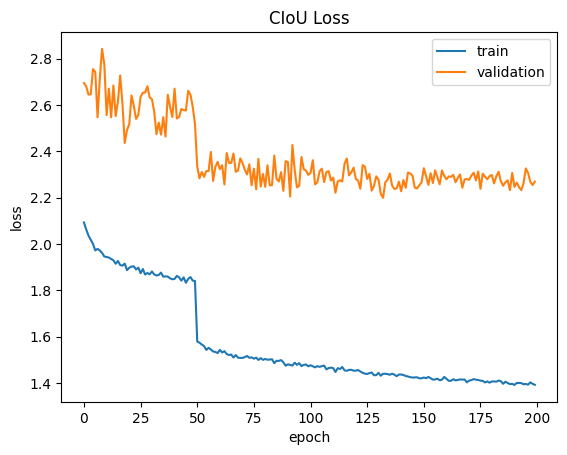

In [32]:
plt.plot(train_loss['ciou'])
plt.plot(test_loss['ciou'])
plt.title('CIoU Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/ciou_loss_{version}.png', bbox_inches='tight')
plt.show()

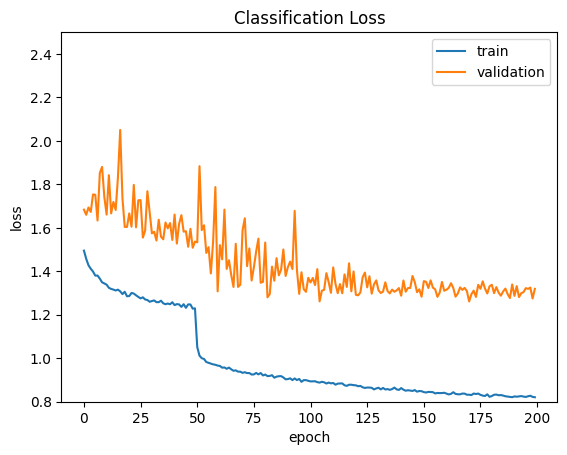

In [33]:
plt.plot(train_loss['cls'])
plt.plot(test_loss['cls'])
plt.ylim(0.8, 2.5)
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/cls_loss_{version}.png', bbox_inches='tight')
plt.show()

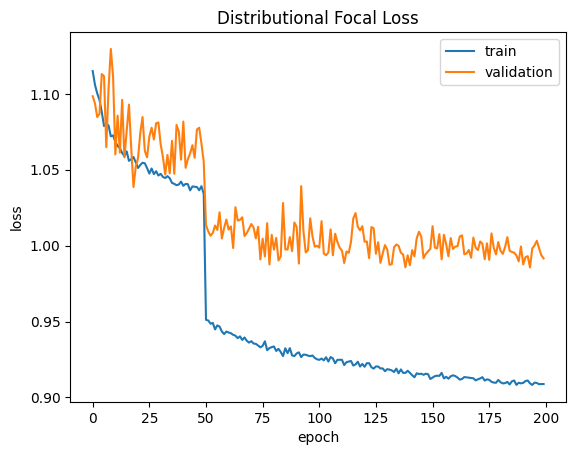

In [34]:
plt.plot(train_loss['dfl'])
plt.plot(test_loss['dfl'])
#plt.ylim(1., 1.4)
plt.title('Distributional Focal Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/dfl_loss_{version}.png', bbox_inches='tight')
plt.show()

In [70]:
train_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(train_loss['ciou'], train_loss['cls'], train_loss['dfl'])]
test_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(test_loss['ciou'], test_loss['cls'], test_loss['dfl'])]

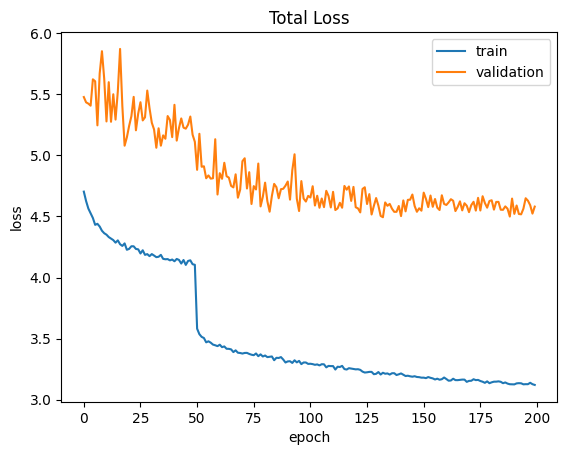

In [72]:
plt.plot(train_loss['total'])
plt.plot(test_loss['total'])
#plt.ylim(5., 7.5)
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(save_pth + f'/total_loss_{version}.png', bbox_inches='tight')
plt.show()

In [49]:
image, bboxes, category_ids = next(iter(dataloader['val']))
trainer.model.eval()
pred = trainer.model(image.to(params['device']))
y = trainer.inference(pred)
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(y.shape)

torch.Size([32, 18, 40, 40])
torch.Size([32, 18, 20, 20])
torch.Size([32, 18, 10, 10])
torch.Size([32, 6, 2100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


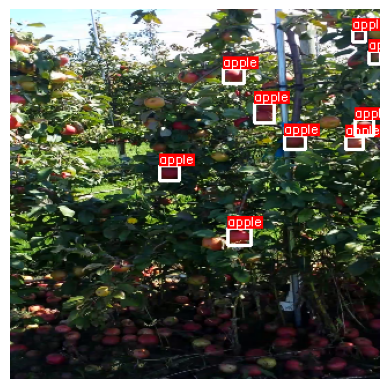

In [50]:
output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

## Import and evaluate trained model

In [63]:
# trained model model_189_v3
if str(params["device"]) == 'cuda':
    model = torch.load('checkpoint/mixed/model_189_v3.pt').to(params["device"])
else:
    model = torch.load('checkpoint/mixed/model_189_v3.pt', map_location=torch.device('cpu')).to(params["device"])
    
model.eval()
print(summary(model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464             464
       ConvModule-2     [1, 16, 320, 320]           4,672           4,672
              C2f-3     [1, 32, 160, 160]           2,688           2,688
       ConvModule-4     [1, 32, 160, 160]          18,560          18,560
              C2f-5       [1, 64, 80, 80]          12,544          12,544
       ConvModule-6       [1, 64, 80, 80]          36,992          36,992
              C2f-7       [1, 64, 40, 40]          12,544          12,544
       ConvModule-8       [1, 64, 40, 40]          36,992          36,992
              C2f-9       [1, 64, 20, 20]          10,496          10,496
            SPPF-10       [1, 64, 20, 20]          20,736          20,736
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

In [53]:
validator = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)
metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params['device'])
        
dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True)}
        
        preds = model(batch['batch_idx'])
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
                
        stream.set_description("{metric_monitor}".format(metric_monitor=metric_monitor))
        
batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator(pred_output, batch, depth=True, plots=True)
print(result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


{'seen': 397, 'instances': 12913, 'P': 0.5442447975571253, 'R': 0.4302972344628246, 'mAP50': 0.43547495146727844, 'mAP50-95': 0.16527948967103542}


In [ ]:
147: {'seen': 397, 'instances': 12913, 'P': 0.5391945739382379, 'R': 0.42894757221404783, 'mAP50': 0.4350890974361756, 'mAP50-95': 0.16552664505080125}
189: {'seen': 397, 'instances': 12913, 'P': 0.5421169362305059, 'R': 0.44395201405763396, 'mAP50': 0.4433509761383612, 'mAP50-95': 0.16716118621624942}

In [69]:
transform = A.Compose([
        #A.SmallestMaxSize (max_size=params['img_size']),
        #A.PadIfNeeded(params['img_size'], params['img_size'], border_mode=0, value=(0.5, 0.5, 0.5)),
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


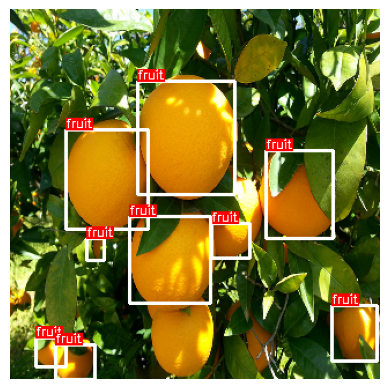

In [64]:
image = read_image('oranges/img1.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


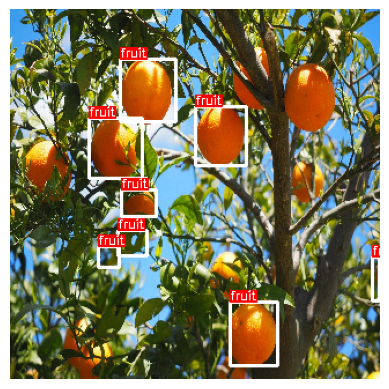

In [65]:
image = read_image('oranges/img2.jpeg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


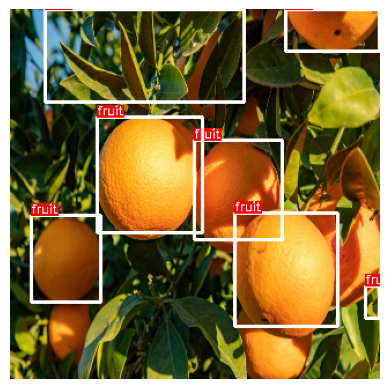

In [66]:
image = read_image('oranges/img3.jpeg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


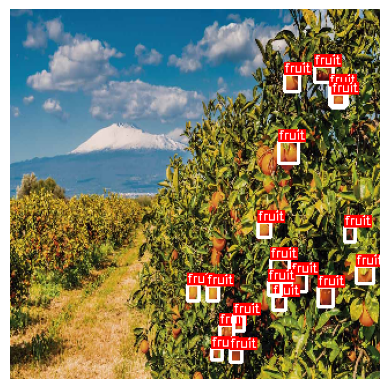

In [67]:
image = read_image('oranges/img4.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image torch.Size([1, 3, 320, 320])
pred[0] torch.Size([1, 18, 40, 40])
pred[1] torch.Size([1, 18, 20, 20])
pred[2] torch.Size([1, 18, 10, 10])
y torch.Size([1, 6, 2100])


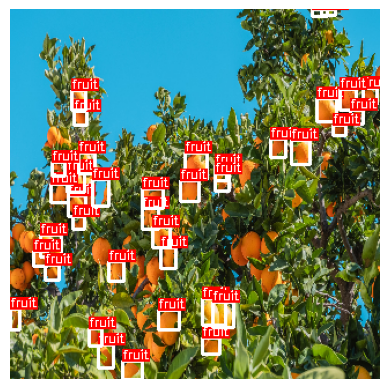

In [68]:
image = read_image('oranges/img5.jpg', ImageReadMode.RGB)

transformed = transform(image=np.array(image.permute(1,2,0), np.float32) / 255.)
image = transformed['image']
image = image.unsqueeze(0)

print(f'image {image.shape}')

pred = model(image.to(params['device']))
print(f'pred[0] {pred[0].shape}')
print(f'pred[1] {pred[1].shape}')
print(f'pred[2] {pred[2].shape}')

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(f'y {y.shape}')

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 18, 40, 40])
torch.Size([32, 18, 20, 20])
torch.Size([32, 18, 10, 10])
torch.Size([32, 6, 2100])


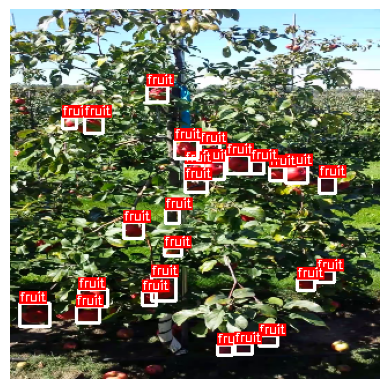

In [60]:
image, bboxes, category_ids = next(iter(dataloader['val']))
pred = model(image.to(params['device']))
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)

inference = Inference(nclasses=len(classes), reg_max=params['reg_max'], stride=torch.tensor([8,16,32]), device=params['device'])
y = inference(pred) # (bs, 4 + nclasses + depth, h*w)
print(y.shape)

output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

## Import and evaluate YOLOv8n

In [81]:
# yolov8n ultralytics model
yolov8n = torch.load('yolov8n.pt', map_location=torch.device('cpu'))
model = yolov8n['model']
model = model.to(torch.float32).to(params["device"])
model.eval()
print(summary(model, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

-----------------------------------------------------------------------------------------------------------
      Layer (type)                                             Input Shape         Param #     Tr. Param #
            Conv-1                                        [1, 3, 320, 320]             464               0
            Conv-2                                       [1, 16, 160, 160]           4,672               0
             C2f-3                                         [1, 32, 80, 80]           7,360               0
            Conv-4                                         [1, 32, 80, 80]          18,560               0
             C2f-5                                         [1, 64, 40, 40]          49,664               0
            Conv-6                                         [1, 64, 40, 40]          73,984               0
             C2f-7                                        [1, 128, 20, 20]         197,632               0
            Conv-8                  

In [86]:
criterion = v8DetectionLoss(device=params['device'],
                            nclasses=len(classes), 
                            stride=torch.tensor([8,16,32]),
                            reg_max=params['reg_max'])

validator = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)

losses_names = ['ciou', 'cls', 'dfl']
metrics_names = ['P','R','mAP50','mAP50-95']
losses = defaultdict(list)
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True)}
        
        y, preds = model(batch['batch_idx'])
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
        
        #loss, loss_items = criterion(preds, batch, depth=False)
        #for j, x in enumerate(loss_items):
            #x = round(float(x), 5)
            #metric_monitor.update(losses_names[j], x)      
        
        result = validator(output, batch, depth=False, plots=False)
        for j,(k) in enumerate(metrics_names):
            metric_monitor.update(metrics_names[j], round(float(result[k]), 5))  
    
        stream.set_description("YOLOv8n loss/metrics. {metric_monitor}".format(metric_monitor=metric_monitor))

YOLOv8n loss/metrics. P: 0.650 | R: 0.464 | mAP50: 0.526 | mAP50-95: 0.378: 100%|███████████████████████████████████████████████████████| 155/155 [00:20<00:00,  7.44it/s]


In [87]:
validator_total = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)

batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator_total(pred_output, batch, depth=False, plots=True)

print(result)

{'seen': 4952, 'instances': 36335, 'P': 0.6016595336836846, 'R': 0.39170536147584845, 'mAP50': 0.41958237732183934, 'mAP50-95': 0.28629281155702513}


In [41]:
image, bboxes, category_ids = next(iter(dataloader['val']))
y, pred = model(image.to(params['device']).half())
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(y.shape)

torch.Size([16, 144, 80, 80])
torch.Size([16, 144, 40, 40])
torch.Size([16, 144, 20, 20])
torch.Size([16, 84, 8400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


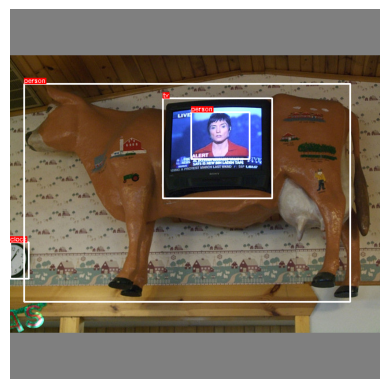

In [43]:
output = non_max_suppression(y) # bbox xyxy, score, cls
visualize_pred(image, output, classes)